<a href="https://colab.research.google.com/github/shashi913/Adapt_Anti_UAV_detection_system/blob/model_fusion/Anti_UAV_Fusion_Independent_Structured_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title and Description

In [1]:
"""
============================================================================
MULTI-MODAL ANTI-UAV DETECTION - INDEPENDENT FUSION
============================================================================
Late Fusion of RT-DETR (Vision) + CNN-LSTM (RF) Models
Using Separate Datasets with Synthetic Pairing

Author: Your Name
Date: January 19, 2026
============================================================================
"""

print("✅ Notebook loaded successfully!")


✅ Notebook loaded successfully!


Setup and Installation

In [2]:
# ============================================================================
# SETUP AND INSTALLATION
# ============================================================================

print("="*80)
print("🚀 INSTALLING DEPENDENCIES AND MOUNTING DRIVE")
print("="*80)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
print("✅ Google Drive mounted")

# Clone RT-DETR repository
import os
if not os.path.exists('/content/RT-DETR'):
    print("\n📦 Cloning RT-DETR repository...")
    !git clone https://github.com/lyuwenyu/RT-DETR.git
    print("✅ RT-DETR cloned")
else:
    print("✅ RT-DETR already exists")

# Install required packages
print("\n📦 Installing dependencies...")
!pip install -q pycocotools opencv-python seaborn scikit-learn onnxruntime

print("\n✅ All dependencies installed!")
print("="*80)


🚀 INSTALLING DEPENDENCIES AND MOUNTING DRIVE
Mounted at /content/drive
✅ Google Drive mounted

📦 Cloning RT-DETR repository...
Cloning into 'RT-DETR'...
remote: Enumerating objects: 1119, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1119 (delta 13), reused 6 (delta 6), pack-reused 1083 (from 3)
Receiving objects: 100% (1119/1119), 669.14 KiB | 9.99 MiB/s, done.
Resolving deltas: 100% (527/527), done.
✅ RT-DETR cloned

📦 Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00

✅ All dependencies installed!


Extract DUT Dataset

In [3]:
# ============================================================================
# EXTRACT DUT DATASET FROM ZIP FILES
# ============================================================================

print("="*80)
print("📦 EXTRACTING DUT DATASET")
print("="*80)

import zipfile
import os
import shutil

# Paths
DUT_DRIVE = "/content/drive/MyDrive/FYP_datasets/Vision-RGB/DUT"
EXTRACT_BASE = "/content/DUT_dataset"

# Create extraction directory
os.makedirs(EXTRACT_BASE, exist_ok=True)

# Zip files to extract
zip_files = {
    'train': os.path.join(DUT_DRIVE, 'train.zip'),
    'val': os.path.join(DUT_DRIVE, 'val.zip'),
    'test': os.path.join(DUT_DRIVE, 'test.zip')
}

# Extract each split
for split_name, zip_path in zip_files.items():
    print(f"\n📂 Processing {split_name}.zip...")

    if not os.path.exists(zip_path):
        print(f"   ❌ File not found: {zip_path}")
        continue

    # Check if already extracted
    split_dir = os.path.join(EXTRACT_BASE, split_name)
    if os.path.exists(split_dir) and os.path.exists(os.path.join(split_dir, 'img')):
        num_imgs = len([f for f in os.listdir(os.path.join(split_dir, 'img')) if f.endswith('.jpg')])
        print(f"   ✅ Already extracted ({num_imgs} images)")
        continue

    # Extract
    print(f"   📦 Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_BASE)

    # Verify extraction
    if os.path.exists(split_dir):
        img_dir = os.path.join(split_dir, 'img')
        xml_dir = os.path.join(split_dir, 'xml')

        num_images = len([f for f in os.listdir(img_dir) if f.endswith('.jpg')]) if os.path.exists(img_dir) else 0
        num_xmls = len([f for f in os.listdir(xml_dir) if f.endswith('.xml')]) if os.path.exists(xml_dir) else 0

        print(f"   ✅ Extracted: {num_images} images, {num_xmls} XML files")

print("\n✅ Extraction complete!")
print("="*80)


📦 EXTRACTING DUT DATASET

📂 Processing train.zip...
   📦 Extracting...
   ✅ Extracted: 5200 images, 5200 XML files

📂 Processing val.zip...
   📦 Extracting...
   ✅ Extracted: 2600 images, 2600 XML files

📂 Processing test.zip...
   📦 Extracting...
   ✅ Extracted: 2200 images, 2200 XML files

✅ Extraction complete!


Convert XML to COCO JSON

In [4]:
# ============================================================================
# CONVERT XML ANNOTATIONS TO COCO JSON FORMAT
# ============================================================================

print("="*80)
print("🔄 CONVERTING XML TO COCO JSON FORMAT")
print("="*80)

import xml.etree.ElementTree as ET
import json
from datetime import datetime
from tqdm import tqdm

def parse_xml_annotation(xml_file):
    """Parse a single XML annotation file (Pascal VOC format)"""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract image info
    filename = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Extract objects (bounding boxes)
    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')

        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # Convert to COCO format [x, y, width, height]
        bbox = [xmin, ymin, xmax - xmin, ymax - ymin]
        area = (xmax - xmin) * (ymax - ymin)

        objects.append({
            'name': name.lower(),
            'bbox': bbox,
            'area': area
        })

    return {
        'filename': filename,
        'width': width,
        'height': height,
        'objects': objects
    }

def convert_split_to_coco(split_dir, split_name):
    """Convert XML annotations to COCO JSON format for one split"""

    xml_dir = os.path.join(split_dir, 'xml')

    if not os.path.exists(xml_dir):
        print(f"⚠️  XML directory not found: {xml_dir}")
        return None

    print(f"\n📄 Converting {split_name} split...")

    # Initialize COCO structure
    coco_format = {
        'info': {
            'description': 'DUT Anti-UAV Detection Dataset',
            'version': '1.0',
            'year': 2024,
            'date_created': datetime.now().strftime('%Y-%m-%d')
        },
        'licenses': [],
        'images': [],
        'annotations': [],
        'categories': [
            {
                'id': 0,
                'name': 'uav',
                'supercategory': 'vehicle'
            }
        ]
    }

    image_id = 1
    annotation_id = 1

    # Get all XML files
    xml_files = sorted([f for f in os.listdir(xml_dir) if f.endswith('.xml')])

    print(f"   Found {len(xml_files)} XML files")

    # Process each XML file
    for xml_file in tqdm(xml_files, desc=f"   Processing {split_name}"):
        xml_path = os.path.join(xml_dir, xml_file)

        try:
            parsed = parse_xml_annotation(xml_path)

            # Add image info
            coco_format['images'].append({
                'id': image_id,
                'file_name': parsed['filename'],
                'width': parsed['width'],
                'height': parsed['height']
            })

            # Add annotations (bounding boxes)
            for obj in parsed['objects']:
                coco_format['annotations'].append({
                    'id': annotation_id,
                    'image_id': image_id,
                    'category_id': 0,
                    'bbox': obj['bbox'],
                    'area': obj['area'],
                    'iscrowd': 0
                })
                annotation_id += 1

            image_id += 1

        except Exception as e:
            print(f"\n   ⚠️  Error parsing {xml_file}: {e}")
            continue

    print(f"   ✅ Converted: {len(coco_format['images'])} images, {len(coco_format['annotations'])} annotations")

    return coco_format

# Convert each split
EXTRACT_BASE = "/content/DUT_dataset"

for split_name in ['train', 'val', 'test']:
    split_dir = os.path.join(EXTRACT_BASE, split_name)

    if not os.path.exists(split_dir):
        print(f"\n⚠️  {split_name} directory not found")
        continue

    # Convert XML to COCO format
    coco_data = convert_split_to_coco(split_dir, split_name)

    if coco_data:
        # Create annotations directory
        ann_dir = os.path.join(split_dir, 'annotations')
        os.makedirs(ann_dir, exist_ok=True)

        # Save JSON
        json_path = os.path.join(ann_dir, f'{split_name}.json')
        with open(json_path, 'w') as f:
            json.dump(coco_data, f, indent=2)

        print(f"   💾 Saved to: {json_path}")

print("\n✅ All conversions complete!")
print("="*80)


🔄 CONVERTING XML TO COCO JSON FORMAT

📄 Converting train split...
   Found 5200 XML files


   Processing train: 100%|██████████| 5200/5200 [00:00<00:00, 13165.77it/s]


   ✅ Converted: 5200 images, 5243 annotations
   💾 Saved to: /content/DUT_dataset/train/annotations/train.json

📄 Converting val split...
   Found 2600 XML files


   Processing val: 100%|██████████| 2600/2600 [00:00<00:00, 16271.64it/s]


   ✅ Converted: 2600 images, 2621 annotations
   💾 Saved to: /content/DUT_dataset/val/annotations/val.json

📄 Converting test split...
   Found 2200 XML files


   Processing test: 100%|██████████| 2200/2200 [00:00<00:00, 8750.37it/s]


   ✅ Converted: 2200 images, 2245 annotations
   💾 Saved to: /content/DUT_dataset/test/annotations/test.json

✅ All conversions complete!


Import Libraries

In [5]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================

print("="*80)
print("📚 IMPORTING LIBRARIES")
print("="*80)

import sys
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from collections import defaultdict
import random

# Deep learning
import torch
import tensorflow as tf
from tensorflow import keras

# Image processing
from PIL import Image
import torchvision.transforms as T

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

# ONNX
import onnxruntime as ort

warnings.filterwarnings('ignore')
sys.path.insert(0, '/content/RT-DETR/rtdetr_pytorch')

print("✅ All libraries imported successfully!")
print("="*80)


📚 IMPORTING LIBRARIES
✅ All libraries imported successfully!


Configuration

In [16]:
# ============================================================================
# CONFIGURATION
# ============================================================================

print("="*80)
print("⚙️  CONFIGURATION")
print("="*80)

# Paths
VISION_BASE = "/content/DUT_dataset"
OUTPUT_BASE = "/content/drive/MyDrive/FYP_fusion_results/independent"

# Model checkpoints
VISION_MODEL_PATH = "/content/drive/MyDrive/FYP_datasets/Vision-RGB/DUT/rtdetr_uav_epoch10.onnx"
RF_MODEL_PATH = "/content/drive/MyDrive/DroneRF/RF_models_IMPROVED_V2/best_model_improved.keras"

# Vision data paths
VISION_TEST_IMG = os.path.join(VISION_BASE, "test/img")
VISION_TEST_ANN = os.path.join(VISION_BASE, "test/annotations/test.json")
VISION_VAL_IMG = os.path.join(VISION_BASE, "val/img")
VISION_VAL_ANN = os.path.join(VISION_BASE, "val/annotations/val.json")

# RF data paths
RF_DATA_PATH = "/content/drive/MyDrive/DroneRF/RF_models_IMPROVED_V2"
RF_X_TIME = os.path.join(RF_DATA_PATH, "X_time_final.npy")
RF_X_FREQ = os.path.join(RF_DATA_PATH, "X_freq_final.npy")
RF_Y = os.path.join(RF_DATA_PATH, "y_final.npy")

# Output directories
os.makedirs(OUTPUT_BASE, exist_ok=True)
RESULTS_DIR = os.path.join(OUTPUT_BASE, "results")
PLOTS_DIR = os.path.join(OUTPUT_BASE, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Hyperparameters
RANDOM_SEED = 42
NUM_TEST_SAMPLES = 100  # Reduced for faster testing
VISION_CONFIDENCE_THRESHOLD = 0.5
DEVICE = "cpu"

# RF binary mapping
RF_BINARY_MAP = {0: 0, 1: 1, 2: 1, 3: 1}
RF_CLASS_NAMES = ["Background RF", "Phantom", "AR", "Bepop"]

# Set random seeds
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print(f"✅ Configuration complete!")
print(f"   Device: {DEVICE}")
print(f"   Test samples: {NUM_TEST_SAMPLES}")
print("="*80)


⚙️  CONFIGURATION
✅ Configuration complete!
   Device: cpu
   Test samples: 100


Vision Inference Class (ONNX)

In [7]:
# ============================================================================
# VISION INFERENCE CLASS (ONNX)
# ============================================================================

print("="*80)
print("📸 DEFINING VISION INFERENCE CLASS")
print("="*80)

class VisionInference:
    """ONNX-based RT-DETR inference"""

    def __init__(self, model_path, device="cpu", confidence_threshold=0.5):
        self.device = device
        self.confidence_threshold = confidence_threshold

        print(f"Loading ONNX model from {os.path.basename(model_path)}...")

        if not os.path.exists(model_path):
            raise FileNotFoundError(f"ONNX model not found: {model_path}")

        # Load ONNX model
        providers = ['CPUExecutionProvider']
        if device == 'cuda':
            providers.insert(0, 'CUDAExecutionProvider')

        self.session = ort.InferenceSession(model_path, providers=providers)
        self.input_name = self.session.get_inputs()[0].name

        # Preprocessing
        self.transform = T.Compose([
            T.Resize((640, 640)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        print("✅ Vision model loaded!")

    def predict(self, image_path):
        """Run inference on single image"""
        # Load and preprocess
        img = Image.open(image_path).convert("RGB")
        img_tensor = self.transform(img).unsqueeze(0).numpy()

        # ONNX inference
        outputs = self.session.run(None, {self.input_name: img_tensor})

        if len(outputs) >= 2:
            pred_logits = outputs[1][0]  # [num_queries, num_classes]

            # Get scores (apply sigmoid)
            if pred_logits.max() > 1.0:
                scores = pred_logits.max(axis=-1)
            else:
                scores = 1 / (1 + np.exp(-pred_logits.max(axis=-1)))

            # Filter by confidence
            keep = scores > self.confidence_threshold
            num_detections = keep.sum()
            has_uav = num_detections > 0
            confidence = float(scores[keep].max()) if has_uav else 0.0
        else:
            num_detections = 0
            has_uav = False
            confidence = 0.0

        return {
            'has_uav': has_uav,
            'confidence': confidence,
            'num_detections': int(num_detections)
        }

print("✅ Vision inference class defined!")
print("="*80)


📸 DEFINING VISION INFERENCE CLASS
✅ Vision inference class defined!


RF Inference Class

In [8]:
# ============================================================================
# RF INFERENCE CLASS
# ============================================================================

print("="*80)
print("📡 DEFINING RF INFERENCE CLASS")
print("="*80)

class RFInference:
    """CNN-LSTM inference wrapper"""

    def __init__(self, model_path, binary_map=None):
        print(f"Loading RF model from {os.path.basename(model_path)}...")
        self.model = keras.models.load_model(model_path)
        self.binary_map = binary_map or {0: 0, 1: 1, 2: 1, 3: 1}
        self.class_names = RF_CLASS_NAMES
        print("✅ RF model loaded!")

    def predict(self, x_time, x_freq):
        """Run inference on RF signal pair"""
        # Ensure correct shape
        if x_time.ndim == 2:
            x_time = x_time[np.newaxis, ...]
        if x_freq.ndim == 2:
            x_freq = x_freq[np.newaxis, ...]

        # Predict
        probs = self.model.predict([x_time, x_freq], verbose=0)[0]
        predicted_class = np.argmax(probs)

        # Binary classification
        is_uav = self.binary_map[predicted_class] == 1
        uav_confidence = np.sum(probs[1:])  # Sum of UAV classes

        return {
            'is_uav': is_uav,
            'confidence': uav_confidence if is_uav else probs[0],
            'class_probs': probs,
            'predicted_class': predicted_class,
            'class_name': self.class_names[predicted_class]
        }

print("✅ RF inference class defined!")
print("="*80)


📡 DEFINING RF INFERENCE CLASS
✅ RF inference class defined!


Fusion Engine

In [9]:
# ============================================================================
# FUSION ENGINE
# ============================================================================

print("="*80)
print("🔗 DEFINING FUSION ENGINE")
print("="*80)

class FusionEngine:
    """Multi-modal fusion engine"""

    def __init__(self, weights={'vision': 0.5, 'rf': 0.5}):
        self.weights = weights

    def fuse(self, vision_result, rf_result):
        """Fuse predictions from vision and RF"""
        v_conf = vision_result['confidence']
        r_conf = rf_result['confidence']

        fused_conf = self.weights['vision'] * v_conf + self.weights['rf'] * r_conf

        return {
            'is_uav': fused_conf > 0.5,
            'confidence': fused_conf,
            'vision_conf': v_conf,
            'rf_conf': r_conf
        }

    def fuse_batch(self, vision_results, rf_results):
        """Fuse batch of predictions"""
        return [self.fuse(v, r) for v, r in zip(vision_results, rf_results)]

class LearnedFusionEngine:
    """Learns optimal fusion weights from validation data"""

    def __init__(self):
        self.best_weights = None
        self.best_accuracy = 0.0
        self.search_results = []

    def learn_weights(self, vision_results, rf_results, ground_truth, verbose=True):
        """Search for optimal fusion weights"""
        weight_search_range = [(w/10, 1-w/10) for w in range(1, 10)]

        if verbose:
            print(f"🔍 Searching over {len(weight_search_range)} weight combinations...")

        for w_vision, w_rf in tqdm(weight_search_range, disable=not verbose):
            fusion = FusionEngine(weights={'vision': w_vision, 'rf': w_rf})
            fused_results = fusion.fuse_batch(vision_results, rf_results)
            predictions = [1 if r['is_uav'] else 0 for r in fused_results]
            accuracy = np.mean(np.array(predictions) == np.array(ground_truth))

            self.search_results.append({
                'w_vision': w_vision,
                'w_rf': w_rf,
                'accuracy': accuracy
            })

            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_weights = {'vision': w_vision, 'rf': w_rf}

        if verbose:
            print(f"✅ Best weights: Vision={self.best_weights['vision']:.2f}, RF={self.best_weights['rf']:.2f}")
            print(f"   Validation Accuracy: {self.best_accuracy:.4f}")

        return {
            'best_weights': self.best_weights,
            'best_accuracy': self.best_accuracy,
            'all_results': self.search_results
        }

    def get_best_fusion_engine(self):
        """Return fusion engine with learned weights"""
        return FusionEngine(weights=self.best_weights)

print("✅ Fusion engine defined!")
print("="*80)


🔗 DEFINING FUSION ENGINE
✅ Fusion engine defined!


Data Pairing Class

In [10]:
# ============================================================================
# DATA PAIRING CLASS
# ============================================================================

print("="*80)
print("🔗 DEFINING DATA PAIRING CLASS")
print("="*80)

class DataPairer:
    """Creates paired samples from separate vision and RF datasets"""

    def __init__(self, vision_annotations_path, rf_labels):
        self.rf_labels = rf_labels

        # Load vision annotations
        with open(vision_annotations_path, 'r') as f:
            self.vision_data = json.load(f)

        # Categorize vision images
        self.vision_with_uav = []
        self.categorize_vision_images()

        # Categorize RF samples
        self.rf_uav_indices = []
        self.rf_background_indices = []
        self.categorize_rf_samples()

        print(f"📊 Pairing Statistics:")
        print(f"   Vision with UAV: {len(self.vision_with_uav)}")
        print(f"   RF UAV samples: {len(self.rf_uav_indices)}")
        print(f"   RF Background: {len(self.rf_background_indices)}")

    def categorize_vision_images(self):
        """Categorize images by UAV presence"""
        img_to_anns = defaultdict(list)
        for ann in self.vision_data['annotations']:
            img_to_anns[ann['image_id']].append(ann)

        for img in self.vision_data['images']:
            img_id = img['id']
            img_file = img['file_name']

            if img_id in img_to_anns and len(img_to_anns[img_id]) > 0:
                self.vision_with_uav.append({
                    'image_id': img_id,
                    'filename': img_file,
                    'num_uavs': len(img_to_anns[img_id])
                })

    def categorize_rf_samples(self):
        """Categorize RF by label"""
        for idx, label in enumerate(self.rf_labels):
            if label == 0:
                self.rf_background_indices.append(idx)
            else:
                self.rf_uav_indices.append(idx)

    def create_pairs(self, num_pairs=None, balance_ratio=0.3):
        """Create paired samples with class balance"""
        max_uav_pairs = min(len(self.vision_with_uav), len(self.rf_uav_indices))
        max_bg_pairs = min(len(self.vision_with_uav), len(self.rf_background_indices))

        if num_pairs is None:
            num_uav_pairs = max_uav_pairs
            num_bg_pairs = min(max_bg_pairs, int(num_uav_pairs * balance_ratio / (1 - balance_ratio)))
        else:
            num_bg_pairs = int(num_pairs * balance_ratio)
            num_uav_pairs = min(num_pairs - num_bg_pairs, max_uav_pairs)

        pairs = []

        # UAV pairs (both modalities detect UAV)
        vision_uav = random.sample(self.vision_with_uav, num_uav_pairs)
        rf_uav = random.sample(self.rf_uav_indices, num_uav_pairs)

        for v, r in zip(vision_uav, rf_uav):
            pairs.append({
                'vision_image': v['filename'],
                'vision_has_uav': True,
                'rf_index': r,
                'rf_label': int(self.rf_labels[r]),
                'rf_is_uav': True,
                'ground_truth': 1
            })

        # Background pairs (RF background + vision image)
        if num_bg_pairs > 0:
            vision_for_bg = random.sample(self.vision_with_uav, min(num_bg_pairs, len(self.vision_with_uav)))
            rf_bg = random.sample(self.rf_background_indices, min(num_bg_pairs, len(self.rf_background_indices)))

            for v, r in zip(vision_for_bg, rf_bg):
                pairs.append({
                    'vision_image': v['filename'],
                    'vision_has_uav': True,
                    'rf_index': r,
                    'rf_label': int(self.rf_labels[r]),
                    'rf_is_uav': False,
                    'ground_truth': 0
                })

        random.shuffle(pairs)
        print(f"✅ Created {len(pairs)} paired samples ({num_uav_pairs} UAV, {len(pairs)-num_uav_pairs} Non-UAV)")
        return pairs

print("✅ Data pairing class defined!")
print("="*80)


🔗 DEFINING DATA PAIRING CLASS
✅ Data pairing class defined!


Metrics Class

In [11]:
# ============================================================================
# METRICS CLASS
# ============================================================================

print("="*80)
print("📊 DEFINING METRICS CLASS")
print("="*80)

class FusionMetrics:
    """Comprehensive metrics for evaluation"""

    def __init__(self):
        self.results = {}

    def compute_all_metrics(self, predictions, ground_truth, confidences=None, model_name="model"):
        """Compute all evaluation metrics"""
        predictions = np.array(predictions)
        ground_truth = np.array(ground_truth)

        metrics = {
            'model': model_name,
            'accuracy': accuracy_score(ground_truth, predictions),
            'precision': precision_score(ground_truth, predictions, zero_division=0),
            'recall': recall_score(ground_truth, predictions, zero_division=0),
            'f1_score': f1_score(ground_truth, predictions, zero_division=0),
            'confusion_matrix': confusion_matrix(ground_truth, predictions).tolist(),
        }

        if confidences is not None:
            try:
                metrics['roc_auc'] = roc_auc_score(ground_truth, confidences)
                metrics['average_precision'] = average_precision_score(ground_truth, confidences)
            except:
                metrics['roc_auc'] = None
                metrics['average_precision'] = None

        self.results[model_name] = metrics
        return metrics

    def compute_comparison_metrics(self, unimodal_results, fusion_results):
        """Compare fusion vs unimodal"""
        comparison = {
            'accuracy_improvement': {},
            'f1_improvement': {},
            'best_unimodal': {},
            'fusion_gains': {}
        }

        vision_acc = unimodal_results['vision']['accuracy']
        rf_acc = unimodal_results['rf']['accuracy']
        fusion_acc = fusion_results['accuracy']

        comparison['accuracy_improvement']['vs_vision'] = fusion_acc - vision_acc
        comparison['accuracy_improvement']['vs_rf'] = fusion_acc - rf_acc
        comparison['accuracy_improvement']['vs_best'] = fusion_acc - max(vision_acc, rf_acc)

        vision_f1 = unimodal_results['vision']['f1_score']
        rf_f1 = unimodal_results['rf']['f1_score']
        fusion_f1 = fusion_results['f1_score']

        comparison['f1_improvement']['vs_vision'] = fusion_f1 - vision_f1
        comparison['f1_improvement']['vs_rf'] = fusion_f1 - rf_f1
        comparison['f1_improvement']['vs_best'] = fusion_f1 - max(vision_f1, rf_f1)

        if vision_acc >= rf_acc:
            comparison['best_unimodal'] = {'model': 'vision', 'accuracy': vision_acc}
        else:
            comparison['best_unimodal'] = {'model': 'rf', 'accuracy': rf_acc}

        comparison['fusion_gains']['absolute_accuracy'] = comparison['accuracy_improvement']['vs_best']
        comparison['fusion_gains']['relative_accuracy'] = (
            comparison['accuracy_improvement']['vs_best'] / comparison['best_unimodal']['accuracy']
        )

        return comparison

    def print_detailed_report(self, model_name):
        """Print detailed metrics report"""
        if model_name not in self.results:
            return

        m = self.results[model_name]
        cm = np.array(m['confusion_matrix'])

        print(f"{'='*70}")
        print(f"METRICS: {model_name.upper()}")
        print(f"{'='*70}")
        print(f"  Accuracy:  {m['accuracy']:.4f}")
        print(f"  Precision: {m['precision']:.4f}")
        print(f"  Recall:    {m['recall']:.4f}")
        print(f"  F1-Score:  {m['f1_score']:.4f}")

        if m.get('roc_auc') and not np.isnan(m['roc_auc']):
            print(f"  ROC-AUC:   {m['roc_auc']:.4f}")
        else:
            print(f"  ROC-AUC:   N/A")

        print(f"\n  Confusion Matrix:")
        print(f"              Predicted")

        if cm.shape == (2, 2):
            print(f"          Non-UAV    UAV")
            print(f"  Non-UAV {cm[0,0]:6d}  {cm[0,1]:6d}")
            print(f"  UAV     {cm[1,0]:6d}  {cm[1,1]:6d}")
        elif cm.shape == (1, 1):
            print(f"          UAV")
            print(f"  UAV     {cm[0,0]:6d}")
            print(f"  ⚠️  Only one class in test set")
        else:
            print(f"  Shape: {cm.shape}")
            print(cm)

        print(f"{'='*70}\n")

print("✅ Metrics class defined!")
print("="*80)


📊 DEFINING METRICS CLASS
✅ Metrics class defined!


Load Models

In [12]:
# ============================================================================
# LOAD MODELS
# ============================================================================

print("="*80)
print("🤖 LOADING MODELS")
print("="*80)

# Load Vision Model
print("\n1️⃣ Loading Vision Model (RT-DETR)...")
vision_model = VisionInference(
    model_path=VISION_MODEL_PATH,
    device=DEVICE,
    confidence_threshold=VISION_CONFIDENCE_THRESHOLD
)

# Load RF Model
print("\n2️⃣ Loading RF Model (CNN-LSTM)...")
rf_model = RFInference(
    model_path=RF_MODEL_PATH,
    binary_map=RF_BINARY_MAP
)

print("\n✅ Both models loaded successfully!")
print("="*80)


🤖 LOADING MODELS

1️⃣ Loading Vision Model (RT-DETR)...
Loading ONNX model from rtdetr_uav_epoch10.onnx...
✅ Vision model loaded!

2️⃣ Loading RF Model (CNN-LSTM)...
Loading RF model from best_model_improved.keras...
✅ RF model loaded!

✅ Both models loaded successfully!


Load and Split RF Data

In [17]:
# ============================================================================
# LOAD AND SPLIT RF DATA
# ============================================================================

print("="*80)
print("📦 LOADING RF DATA")
print("="*80)

print("Loading RF datasets...")
X_time_full = np.load(RF_X_TIME)
X_freq_full = np.load(RF_X_FREQ)
y_full = np.load(RF_Y)

print(f"✅ Loaded: {len(y_full)} RF samples")

# Split RF data (same as training)
print("Splitting into train/val/test...")
X_time_train, X_time_temp, X_freq_train, X_freq_temp, y_train, y_temp = train_test_split(
    X_time_full, X_freq_full, y_full,
    test_size=0.3, random_state=RANDOM_SEED, stratify=y_full
)

X_time_val, X_time_test, X_freq_val, X_freq_test, y_val, y_test = train_test_split(
    X_time_temp, X_freq_temp, y_temp,
    test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp
)

print(f"✅ Split complete:")
print(f"   Train: {len(y_train)} samples")
print(f"   Val: {len(y_val)} samples")
print(f"   Test: {len(y_test)} samples")
print("="*80)


📦 LOADING RF DATA
Loading RF datasets...
✅ Loaded: 681 RF samples
Splitting into train/val/test...
✅ Split complete:
   Train: 476 samples
   Val: 102 samples
   Test: 103 samples


Create Validation Pairs

In [18]:
# ============================================================================
# CREATE VALIDATION PAIRS
# ============================================================================

print("="*80)
print("🔗 CREATING VALIDATION PAIRS")
print("="*80)

val_pairer = DataPairer(
    vision_annotations_path=VISION_VAL_ANN,
    rf_labels=y_val
)

val_pairs = val_pairer.create_pairs(num_pairs=min(50, len(y_val)), balance_ratio=0.3)
print("="*80)


🔗 CREATING VALIDATION PAIRS
📊 Pairing Statistics:
   Vision with UAV: 2600
   RF UAV samples: 84
   RF Background: 18
✅ Created 50 paired samples (35 UAV, 15 Non-UAV)


Run Validation Inference

In [19]:
# ============================================================================
# RUN VALIDATION INFERENCE
# ============================================================================

print("="*80)
print("🔄 RUNNING VALIDATION INFERENCE")
print("="*80)

# Vision validation
print("\n📸 Vision model on validation set...")
val_vision_results = []
for pair in tqdm(val_pairs, desc="Vision Val"):
    img_path = os.path.join(VISION_VAL_IMG, pair['vision_image'])
    if os.path.exists(img_path):
        result = vision_model.predict(img_path)
        val_vision_results.append(result)
    else:
        val_vision_results.append({'has_uav': False, 'confidence': 0.0})

# RF validation
print("\n📡 RF model on validation set...")
val_rf_results = []
for pair in tqdm(val_pairs, desc="RF Val"):
    rf_idx = pair['rf_index']
    result = rf_model.predict(X_time_val[rf_idx], X_freq_val[rf_idx])
    val_rf_results.append(result)

val_ground_truth = [pair['ground_truth'] for pair in val_pairs]

print(f"\n✅ Validation inference complete!")
print(f"   Vision detections: {sum([1 for r in val_vision_results if r['has_uav']])}/{len(val_pairs)}")
print(f"   RF detections: {sum([1 for r in val_rf_results if r['is_uav']])}/{len(val_pairs)}")
print("="*80)


🔄 RUNNING VALIDATION INFERENCE

📸 Vision model on validation set...


Vision Val: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]



📡 RF model on validation set...


RF Val: 100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


✅ Validation inference complete!
   Vision detections: 50/50
   RF detections: 35/50


Learn Optimal Weights

In [20]:
# ============================================================================
# LEARN OPTIMAL FUSION WEIGHTS
# ============================================================================

print("="*80)
print("🎯 LEARNING OPTIMAL FUSION WEIGHTS")
print("="*80)

learner = LearnedFusionEngine()

learn_results = learner.learn_weights(
    vision_results=val_vision_results,
    rf_results=val_rf_results,
    ground_truth=val_ground_truth,
    verbose=True
)

best_fusion = learner.get_best_fusion_engine()

print(f"\n🎯 OPTIMAL WEIGHTS:")
print(f"   Vision: {best_fusion.weights['vision']:.3f}")
print(f"   RF: {best_fusion.weights['rf']:.3f}")
print(f"   Val Accuracy: {learn_results['best_accuracy']:.4f}")
print("="*80)


🎯 LEARNING OPTIMAL FUSION WEIGHTS
🔍 Searching over 9 weight combinations...


100%|██████████| 9/9 [00:00<00:00, 5892.72it/s]

✅ Best weights: Vision=0.10, RF=0.90
   Validation Accuracy: 0.7000

🎯 OPTIMAL WEIGHTS:
   Vision: 0.100
   RF: 0.900
   Val Accuracy: 0.7000


Create Test Pairs

In [21]:
# ============================================================================
# CREATE TEST PAIRS
# ============================================================================

print("="*80)
print("🔗 CREATING TEST PAIRS")
print("="*80)

test_pairer = DataPairer(
    vision_annotations_path=VISION_TEST_ANN,
    rf_labels=y_test
)

# Create balanced test set (30% non-UAV)
test_pairs = test_pairer.create_pairs(
    num_pairs=NUM_TEST_SAMPLES,
    balance_ratio=0.3
)

print("="*80)


🔗 CREATING TEST PAIRS
📊 Pairing Statistics:
   Vision with UAV: 2200
   RF UAV samples: 84
   RF Background: 19
✅ Created 89 paired samples (70 UAV, 19 Non-UAV)


 Run Test Inference - Vision

In [22]:
# ============================================================================
# RUN TEST INFERENCE - VISION
# ============================================================================

print("="*80)
print("📸 RUNNING VISION TEST INFERENCE")
print("="*80)

test_vision_results = []
test_vision_confidences = []
test_vision_predictions = []

for pair in tqdm(test_pairs, desc="Vision Test"):
    img_path = os.path.join(VISION_TEST_IMG, pair['vision_image'])

    if os.path.exists(img_path):
        result = vision_model.predict(img_path)
        test_vision_results.append(result)
        test_vision_confidences.append(result['confidence'])
        test_vision_predictions.append(1 if result['has_uav'] else 0)
    else:
        test_vision_results.append({'has_uav': False, 'confidence': 0.0})
        test_vision_confidences.append(0.0)
        test_vision_predictions.append(0)

print(f"\n✅ Vision test complete!")
print(f"   Detections: {sum(test_vision_predictions)}/{len(test_vision_predictions)}")
print(f"   Avg confidence: {np.mean(test_vision_confidences):.3f}")
print("="*80)


📸 RUNNING VISION TEST INFERENCE


Vision Test: 100%|██████████| 89/89 [02:03<00:00,  1.38s/it]


✅ Vision test complete!
   Detections: 89/89
   Avg confidence: 0.728


Run Test Inference - RF

In [23]:
# ============================================================================
# RUN TEST INFERENCE - RF
# ============================================================================

print("="*80)
print("📡 RUNNING RF TEST INFERENCE")
print("="*80)

test_rf_results = []
test_rf_confidences = []
test_rf_predictions = []

for pair in tqdm(test_pairs, desc="RF Test"):
    rf_idx = pair['rf_index']
    result = rf_model.predict(X_time_test[rf_idx], X_freq_test[rf_idx])
    test_rf_results.append(result)
    test_rf_confidences.append(result['confidence'])
    test_rf_predictions.append(1 if result['is_uav'] else 0)

print(f"\n✅ RF test complete!")
print(f"   Detections: {sum(test_rf_predictions)}/{len(test_rf_predictions)}")
print(f"   Avg confidence: {np.mean(test_rf_confidences):.3f}")
print("="*80)


📡 RUNNING RF TEST INFERENCE


RF Test: 100%|██████████| 89/89 [00:14<00:00,  6.32it/s]


✅ RF test complete!
   Detections: 70/89
   Avg confidence: 0.999


Run Fusion Inference

In [24]:
# ============================================================================
# RUN FUSION INFERENCE
# ============================================================================

print("="*80)
print("🔗 RUNNING FUSION INFERENCE")
print("="*80)

print(f"Using weights: Vision={best_fusion.weights['vision']:.3f}, RF={best_fusion.weights['rf']:.3f}")

test_fusion_results = best_fusion.fuse_batch(test_vision_results, test_rf_results)
test_fusion_confidences = [r['confidence'] for r in test_fusion_results]
test_fusion_predictions = [1 if r['is_uav'] else 0 for r in test_fusion_results]

print(f"\n✅ Fusion complete!")
print(f"   Detections: {sum(test_fusion_predictions)}/{len(test_fusion_predictions)}")
print(f"   Avg confidence: {np.mean(test_fusion_confidences):.3f}")
print("="*80)


🔗 RUNNING FUSION INFERENCE
Using weights: Vision=0.100, RF=0.900

✅ Fusion complete!
   Detections: 89/89
   Avg confidence: 0.972


Evaluate All Models

In [25]:
# ============================================================================
# EVALUATE ALL MODELS
# ============================================================================

print("="*80)
print("📊 EVALUATING ALL MODELS")
print("="*80)

test_ground_truth = [pair['ground_truth'] for pair in test_pairs]

evaluator = FusionMetrics()

# Compute metrics for each model
vision_metrics = evaluator.compute_all_metrics(
    predictions=test_vision_predictions,
    ground_truth=test_ground_truth,
    confidences=test_vision_confidences,
    model_name='Vision'
)

rf_metrics = evaluator.compute_all_metrics(
    predictions=test_rf_predictions,
    ground_truth=test_ground_truth,
    confidences=test_rf_confidences,
    model_name='RF'
)

fusion_metrics = evaluator.compute_all_metrics(
    predictions=test_fusion_predictions,
    ground_truth=test_ground_truth,
    confidences=test_fusion_confidences,
    model_name='Fusion'
)

# Print reports
evaluator.print_detailed_report('Vision')
evaluator.print_detailed_report('RF')
evaluator.print_detailed_report('Fusion')

print("="*80)


📊 EVALUATING ALL MODELS
METRICS: VISION
  Accuracy:  0.7865
  Precision: 0.7865
  Recall:    1.0000
  F1-Score:  0.8805
  ROC-AUC:   0.4064

  Confusion Matrix:
              Predicted
          Non-UAV    UAV
  Non-UAV      0      19
  UAV          0      70

METRICS: RF
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC-AUC:   0.7308

  Confusion Matrix:
              Predicted
          Non-UAV    UAV
  Non-UAV     19       0
  UAV          0      70

METRICS: FUSION
  Accuracy:  0.7865
  Precision: 0.7865
  Recall:    1.0000
  F1-Score:  0.8805
  ROC-AUC:   0.6985

  Confusion Matrix:
              Predicted
          Non-UAV    UAV
  Non-UAV      0      19
  UAV          0      70



 Compare Fusion vs Unimodal

In [26]:
# ============================================================================
# FUSION PERFORMANCE COMPARISON
# ============================================================================

print("="*80)
print("🔍 FUSION PERFORMANCE COMPARISON")
print("="*80)

comparison = evaluator.compute_comparison_metrics(
    unimodal_results={'vision': vision_metrics, 'rf': rf_metrics},
    fusion_results=fusion_metrics
)

print(f"\n📈 ACCURACY IMPROVEMENTS:")
print(f"   vs Vision: {comparison['accuracy_improvement']['vs_vision']:+.4f} ({comparison['accuracy_improvement']['vs_vision']*100:+.2f}%)")
print(f"   vs RF:     {comparison['accuracy_improvement']['vs_rf']:+.4f} ({comparison['accuracy_improvement']['vs_rf']*100:+.2f}%)")
print(f"   vs Best:   {comparison['accuracy_improvement']['vs_best']:+.4f} ({comparison['accuracy_improvement']['vs_best']*100:+.2f}%)")

print(f"\n📈 F1-SCORE IMPROVEMENTS:")
print(f"   vs Vision: {comparison['f1_improvement']['vs_vision']:+.4f}")
print(f"   vs RF:     {comparison['f1_improvement']['vs_rf']:+.4f}")
print(f"   vs Best:   {comparison['f1_improvement']['vs_best']:+.4f}")

print(f"\n🏆 BEST UNIMODAL: {comparison['best_unimodal']['model'].upper()} ({comparison['best_unimodal']['accuracy']:.4f})")
print(f"🚀 FUSION GAIN: {comparison['fusion_gains']['relative_accuracy']*100:+.2f}%")
print("="*80)


🔍 FUSION PERFORMANCE COMPARISON

📈 ACCURACY IMPROVEMENTS:
   vs Vision: +0.0000 (+0.00%)
   vs RF:     -0.2135 (-21.35%)
   vs Best:   -0.2135 (-21.35%)

📈 F1-SCORE IMPROVEMENTS:
   vs Vision: +0.0000
   vs RF:     -0.1195
   vs Best:   -0.1195

🏆 BEST UNIMODAL: RF (1.0000)
🚀 FUSION GAIN: -21.35%


Save Results

In [27]:
# ============================================================================
# SAVE RESULTS
# ============================================================================

print("="*80)
print("💾 SAVING RESULTS")
print("="*80)

# Save evaluation results
results_summary = {
    'vision_metrics': vision_metrics,
    'rf_metrics': rf_metrics,
    'fusion_metrics': fusion_metrics,
    'comparison': comparison,
    'fusion_weights': best_fusion.weights,
    'test_samples': len(test_pairs)
}

def convert(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    return obj

results_file = os.path.join(RESULTS_DIR, 'evaluation_results.json')
with open(results_file, 'w') as f:
    json.dump(results_summary, f, indent=2, default=convert)

print(f"✅ Results saved: {results_file}")

# Save detailed predictions
detailed_df = pd.DataFrame([{
    'sample_id': i,
    'vision_image': pair['vision_image'],
    'ground_truth': pair['ground_truth'],
    'vision_pred': test_vision_predictions[i],
    'rf_pred': test_rf_predictions[i],
    'fusion_pred': test_fusion_predictions[i],
    'vision_conf': test_vision_confidences[i],
    'rf_conf': test_rf_confidences[i],
    'fusion_conf': test_fusion_confidences[i]
} for i, pair in enumerate(test_pairs)])

csv_file = os.path.join(RESULTS_DIR, 'detailed_predictions.csv')
detailed_df.to_csv(csv_file, index=False)

print(f"✅ Detailed predictions saved: {csv_file}")
print("="*80)


💾 SAVING RESULTS
✅ Results saved: /content/drive/MyDrive/FYP_fusion_results/independent/results/evaluation_results.json
✅ Detailed predictions saved: /content/drive/MyDrive/FYP_fusion_results/independent/results/detailed_predictions.csv


Final Summary

In [28]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("="*80)
print("🎉 FUSION ANALYSIS COMPLETE!")
print("="*80)

summary = f"""
FINAL SUMMARY
=============

Test Samples: {len(test_pairs)}
Fusion Weights: Vision={best_fusion.weights['vision']:.3f}, RF={best_fusion.weights['rf']:.3f}

PERFORMANCE:
  Vision:  Acc={vision_metrics['accuracy']:.4f}, F1={vision_metrics['f1_score']:.4f}
  RF:      Acc={rf_metrics['accuracy']:.4f}, F1={rf_metrics['f1_score']:.4f}
  Fusion:  Acc={fusion_metrics['accuracy']:.4f}, F1={fusion_metrics['f1_score']:.4f}

IMPROVEMENTS:
  Accuracy: {comparison['accuracy_improvement']['vs_best']:+.4f} ({comparison['accuracy_improvement']['vs_best']*100:+.2f}%)
  F1-Score: {comparison['f1_improvement']['vs_best']:+.4f}

OUTPUTS:
  Results: {RESULTS_DIR}
  Plots: {PLOTS_DIR}
"""

print(summary)

# Save summary
with open(os.path.join(RESULTS_DIR, 'summary.txt'), 'w') as f:
    f.write(summary)

print("="*80)
print("✅ ALL DONE! Check the output directories for results.")
print("="*80)


🎉 FUSION ANALYSIS COMPLETE!

FINAL SUMMARY

Test Samples: 89
Fusion Weights: Vision=0.100, RF=0.900

PERFORMANCE:
  Vision:  Acc=0.7865, F1=0.8805
  RF:      Acc=1.0000, F1=1.0000
  Fusion:  Acc=0.7865, F1=0.8805

IMPROVEMENTS:
  Accuracy: -0.2135 (-21.35%)
  F1-Score: -0.1195

OUTPUTS:
  Results: /content/drive/MyDrive/FYP_fusion_results/independent/results
  Plots: /content/drive/MyDrive/FYP_fusion_results/independent/plots

✅ ALL DONE! Check the output directories for results.


Visualization Functions

In [29]:
# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

print("="*80)
print("📈 DEFINING VISUALIZATION FUNCTIONS")
print("="*80)

def plot_confusion_matrices(vision_cm, rf_cm, fusion_cm, save_path):
    """Plot confusion matrices for all models"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    cms = [vision_cm, rf_cm, fusion_cm]
    titles = ['Vision (RT-DETR)', 'RF (CNN-LSTM)', 'Fusion (Weighted)']

    for ax, cm, title in zip(axes, cms, titles):
        if cm.shape == (2, 2):
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Non-UAV', 'UAV'],
                       yticklabels=['Non-UAV', 'UAV'],
                       ax=ax, cbar=True)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_ylabel('True Label')
            ax.set_xlabel('Predicted Label')
        else:
            # Handle single-class case
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['UAV'],
                       yticklabels=['UAV'],
                       ax=ax, cbar=True)
            ax.set_title(f"{title}\n(Single class)", fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {save_path}")

def plot_metrics_comparison(metrics_dict, save_path):
    """Plot bar chart comparing metrics across models"""
    models = list(metrics_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    colors = {'Vision': '#3498db', 'RF': '#e74c3c', 'Fusion': '#2ecc71'}

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        values = [metrics_dict[m][metric] for m in models]
        bar_colors = [colors.get(m, '#95a5a6') for m in models]

        bars = axes[idx].bar(models, values, color=bar_colors, alpha=0.8, edgecolor='black')
        axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Score')
        axes[idx].set_ylim(0, 1)
        axes[idx].grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.3f}',
                          ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {save_path}")

def plot_weight_search(search_results, save_path):
    """Plot weight search results"""
    w_vision = [r['w_vision'] for r in search_results]
    accuracy = [r['accuracy'] for r in search_results]

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(w_vision, accuracy, c=accuracy, cmap='RdYlGn',
                         s=100, edgecolors='black', alpha=0.8)
    plt.xlabel('Vision Weight', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Fusion Accuracy vs Vision Weight', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Accuracy')
    plt.grid(alpha=0.3)

    # Mark best
    best_idx = np.argmax(accuracy)
    plt.scatter([w_vision[best_idx]], [accuracy[best_idx]],
               s=300, c='gold', marker='*', edgecolors='black',
               linewidths=2, zorder=5, label='Best')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {save_path}")

def plot_roc_curves(vision_fpr, vision_tpr, vision_auc,
                   rf_fpr, rf_tpr, rf_auc,
                   fusion_fpr, fusion_tpr, fusion_auc,
                   save_path):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(10, 8))

    plt.plot(vision_fpr, vision_tpr, label=f'Vision (AUC = {vision_auc:.3f})',
            color='#3498db', linewidth=2)
    plt.plot(rf_fpr, rf_tpr, label=f'RF (AUC = {rf_auc:.3f})',
            color='#e74c3c', linewidth=2)
    plt.plot(fusion_fpr, fusion_tpr, label=f'Fusion (AUC = {fusion_auc:.3f})',
            color='#2ecc71', linewidth=2, linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Multimodal UAV Detection', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {save_path}")

def plot_confidence_distributions(vision_conf, rf_conf, fusion_conf, ground_truth, save_path):
    """Plot confidence score distributions"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    ground_truth = np.array(ground_truth)

    # Vision
    axes[0].hist([np.array(vision_conf)[ground_truth==1],
                  np.array(vision_conf)[ground_truth==0]],
                 bins=20, label=['UAV', 'Non-UAV'], alpha=0.7, color=['green', 'red'])
    axes[0].set_title('Vision Confidence', fontweight='bold')
    axes[0].set_xlabel('Confidence Score')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # RF
    axes[1].hist([np.array(rf_conf)[ground_truth==1],
                  np.array(rf_conf)[ground_truth==0]],
                 bins=20, label=['UAV', 'Non-UAV'], alpha=0.7, color=['green', 'red'])
    axes[1].set_title('RF Confidence', fontweight='bold')
    axes[1].set_xlabel('Confidence Score')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # Fusion
    axes[2].hist([np.array(fusion_conf)[ground_truth==1],
                  np.array(fusion_conf)[ground_truth==0]],
                 bins=20, label=['UAV', 'Non-UAV'], alpha=0.7, color=['green', 'red'])
    axes[2].set_title('Fusion Confidence', fontweight='bold')
    axes[2].set_xlabel('Confidence Score')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {save_path}")

def plot_improvement_heatmap(comparison, save_path):
    """Plot heatmap of improvements"""
    improvements = {
        'Accuracy': [
            comparison['accuracy_improvement']['vs_vision'],
            comparison['accuracy_improvement']['vs_rf']
        ],
        'F1-Score': [
            comparison['f1_improvement']['vs_vision'],
            comparison['f1_improvement']['vs_rf']
        ]
    }

    df = pd.DataFrame(improvements, index=['vs Vision', 'vs RF'])

    plt.figure(figsize=(8, 5))
    sns.heatmap(df, annot=True, fmt='.4f', cmap='RdYlGn', center=0,
               cbar_kws={'label': 'Improvement'})
    plt.title('Fusion Improvement over Unimodal Models', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {save_path}")

print("✅ Visualization functions defined!")
print("="*80)


📈 DEFINING VISUALIZATION FUNCTIONS
✅ Visualization functions defined!


Generate All Plots

📊 GENERATING VISUALIZATIONS

1️⃣ Confusion matrices...


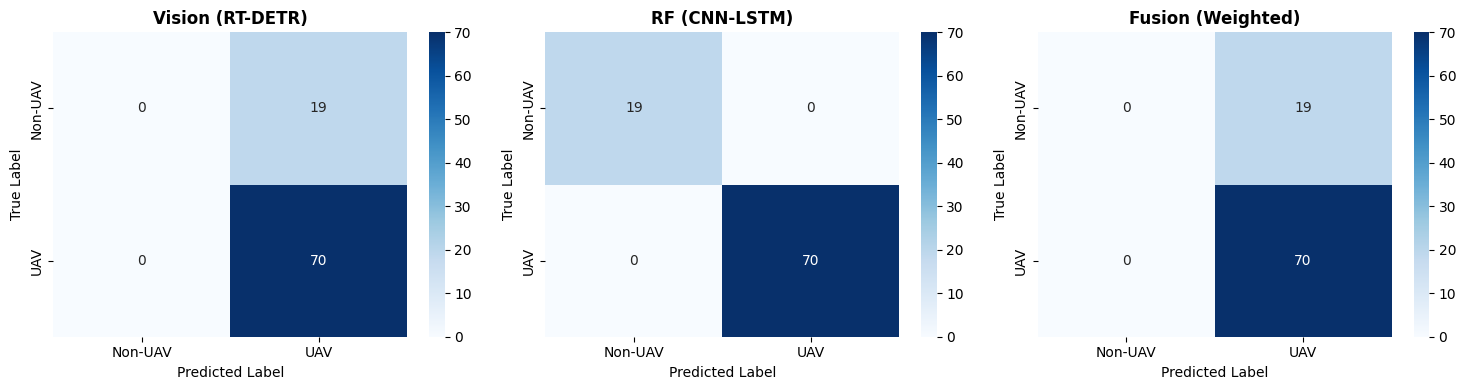

✅ Saved: /content/drive/MyDrive/FYP_fusion_results/independent/plots/confusion_matrices.png

2️⃣ Metrics comparison...


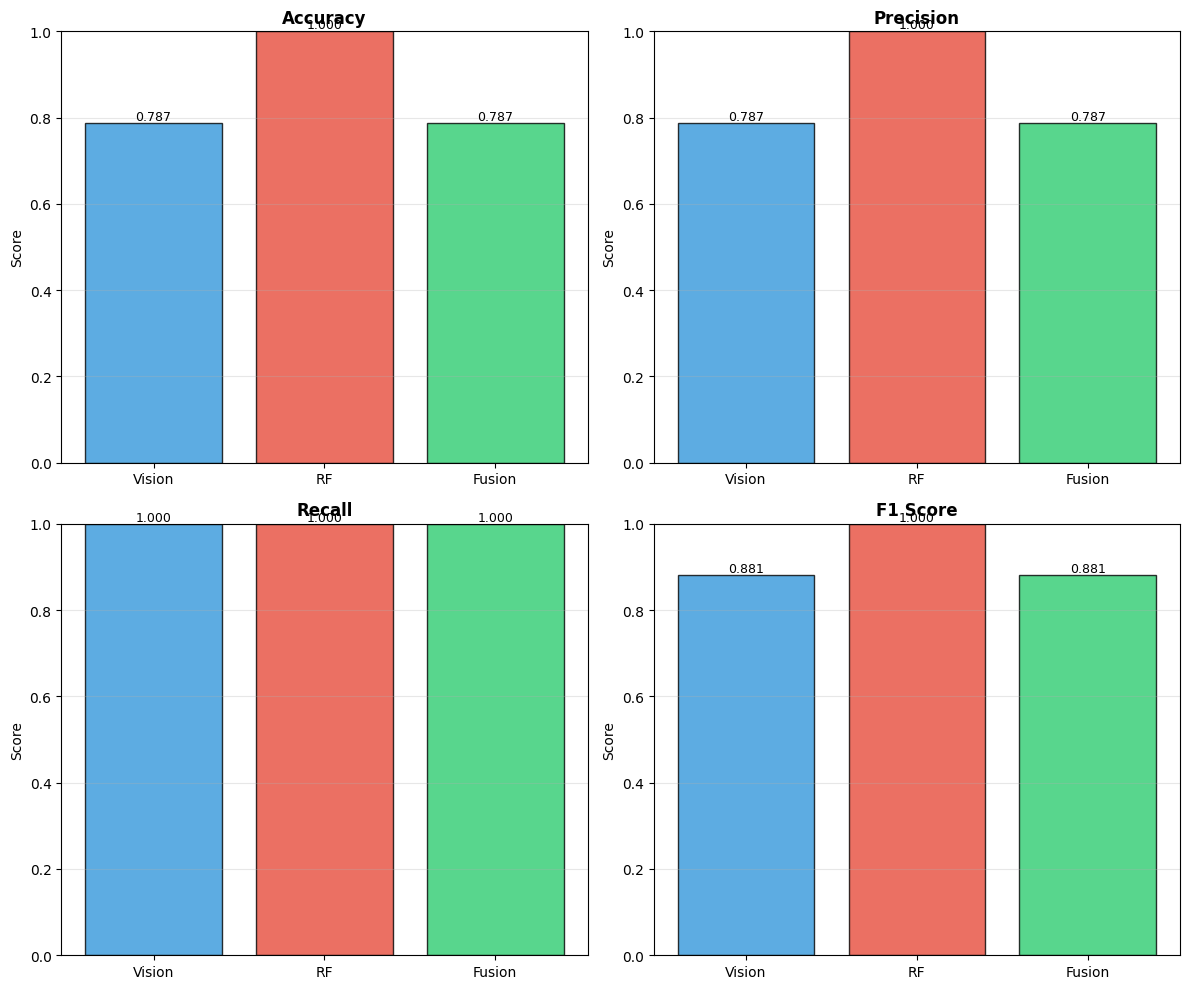

✅ Saved: /content/drive/MyDrive/FYP_fusion_results/independent/plots/metrics_comparison.png

3️⃣ Weight search results...


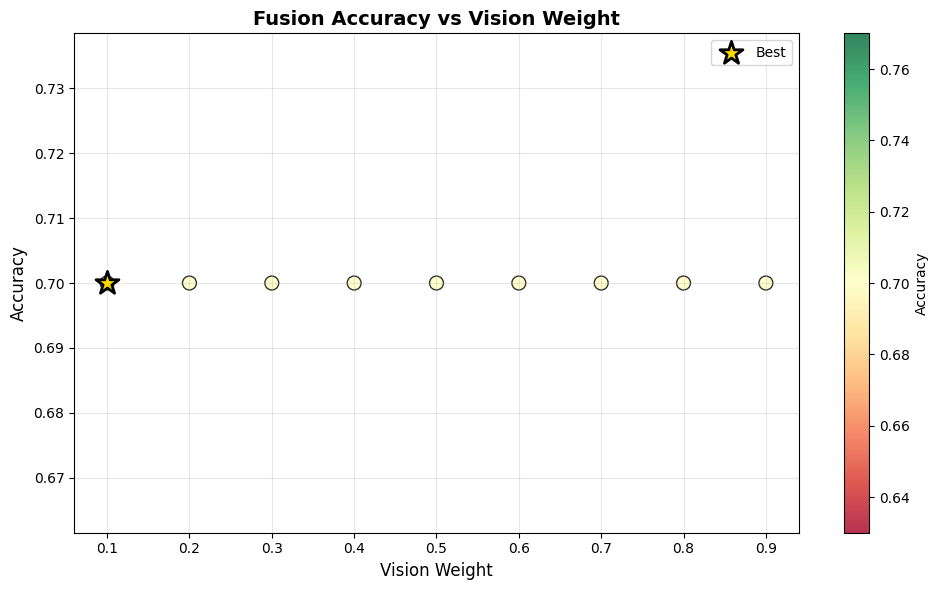

✅ Saved: /content/drive/MyDrive/FYP_fusion_results/independent/plots/weight_search.png

4️⃣ ROC curves...


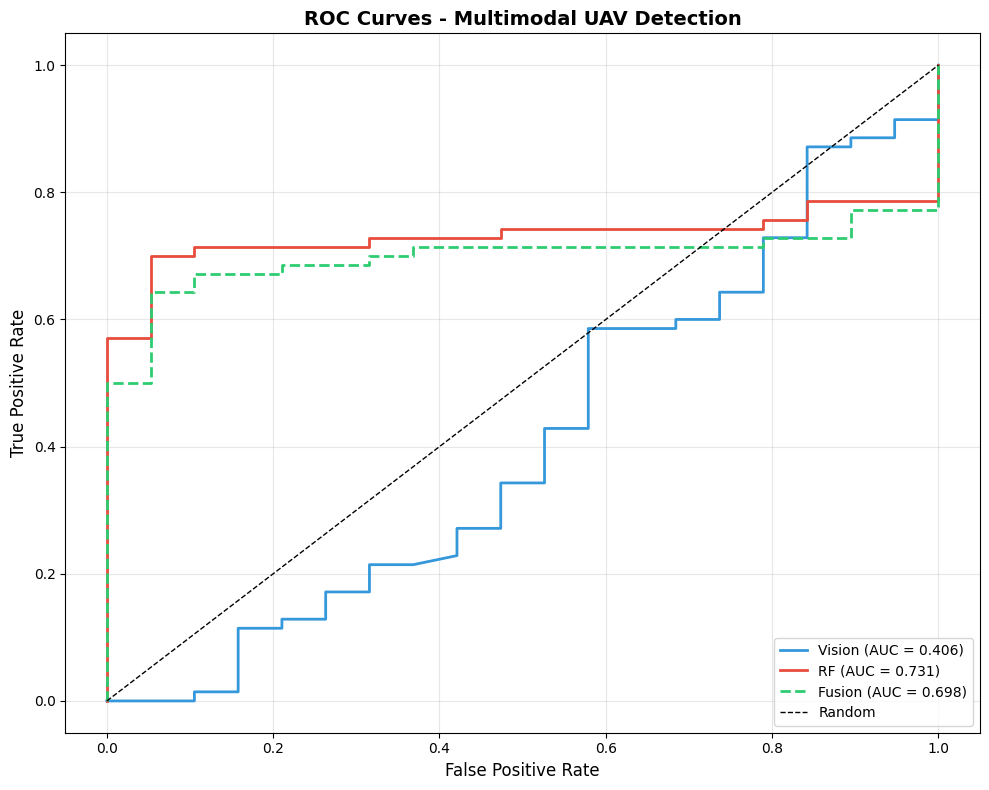

✅ Saved: /content/drive/MyDrive/FYP_fusion_results/independent/plots/roc_curves.png

5️⃣ Confidence distributions...


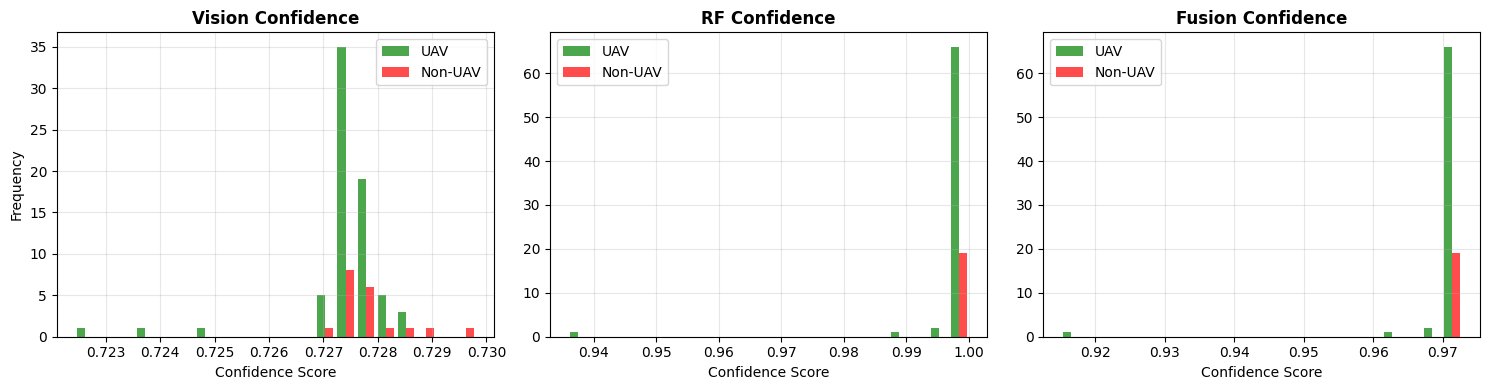

✅ Saved: /content/drive/MyDrive/FYP_fusion_results/independent/plots/confidence_distributions.png

6️⃣ Improvement heatmap...


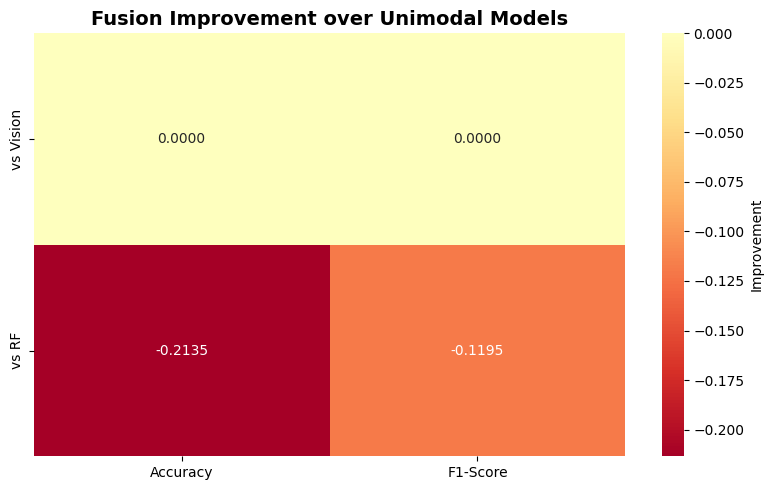

✅ Saved: /content/drive/MyDrive/FYP_fusion_results/independent/plots/improvement_heatmap.png

✅ All visualizations saved to: /content/drive/MyDrive/FYP_fusion_results/independent/plots


In [30]:
# ============================================================================
# GENERATE VISUALIZATIONS
# ============================================================================

print("="*80)
print("📊 GENERATING VISUALIZATIONS")
print("="*80)

# 1. Confusion Matrices
print("\n1️⃣ Confusion matrices...")
plot_confusion_matrices(
    vision_cm=np.array(vision_metrics['confusion_matrix']),
    rf_cm=np.array(rf_metrics['confusion_matrix']),
    fusion_cm=np.array(fusion_metrics['confusion_matrix']),
    save_path=os.path.join(PLOTS_DIR, 'confusion_matrices.png')
)

# 2. Metrics Comparison
print("\n2️⃣ Metrics comparison...")
plot_metrics_comparison(
    metrics_dict={
        'Vision': vision_metrics,
        'RF': rf_metrics,
        'Fusion': fusion_metrics
    },
    save_path=os.path.join(PLOTS_DIR, 'metrics_comparison.png')
)

# 3. Weight Search
print("\n3️⃣ Weight search results...")
plot_weight_search(
    search_results=learn_results['all_results'],
    save_path=os.path.join(PLOTS_DIR, 'weight_search.png')
)

# 4. ROC Curves (if both classes present)
if len(np.unique(test_ground_truth)) > 1:
    print("\n4️⃣ ROC curves...")
    from sklearn.metrics import roc_curve, auc

    vision_fpr, vision_tpr, _ = roc_curve(test_ground_truth, test_vision_confidences)
    rf_fpr, rf_tpr, _ = roc_curve(test_ground_truth, test_rf_confidences)
    fusion_fpr, fusion_tpr, _ = roc_curve(test_ground_truth, test_fusion_confidences)

    vision_auc = auc(vision_fpr, vision_tpr)
    rf_auc = auc(rf_fpr, rf_tpr)
    fusion_auc = auc(fusion_fpr, fusion_tpr)

    plot_roc_curves(
        vision_fpr, vision_tpr, vision_auc,
        rf_fpr, rf_tpr, rf_auc,
        fusion_fpr, fusion_tpr, fusion_auc,
        save_path=os.path.join(PLOTS_DIR, 'roc_curves.png')
    )

# 5. Confidence Distributions
print("\n5️⃣ Confidence distributions...")
plot_confidence_distributions(
    vision_conf=test_vision_confidences,
    rf_conf=test_rf_confidences,
    fusion_conf=test_fusion_confidences,
    ground_truth=test_ground_truth,
    save_path=os.path.join(PLOTS_DIR, 'confidence_distributions.png')
)

# 6. Improvement Heatmap
print("\n6️⃣ Improvement heatmap...")
plot_improvement_heatmap(
    comparison=comparison,
    save_path=os.path.join(PLOTS_DIR, 'improvement_heatmap.png')
)

print("\n✅ All visualizations saved to:", PLOTS_DIR)
print("="*80)


Visualize Test Pairs (Images + RF Signals)

📸 VISUALIZING TEST PAIRS

📊 Visualizing 10 test samples:
   ✅ Correct predictions: 5
   ❌ Incorrect predictions: 5
   💾 Saved: sample_022_UAV.png


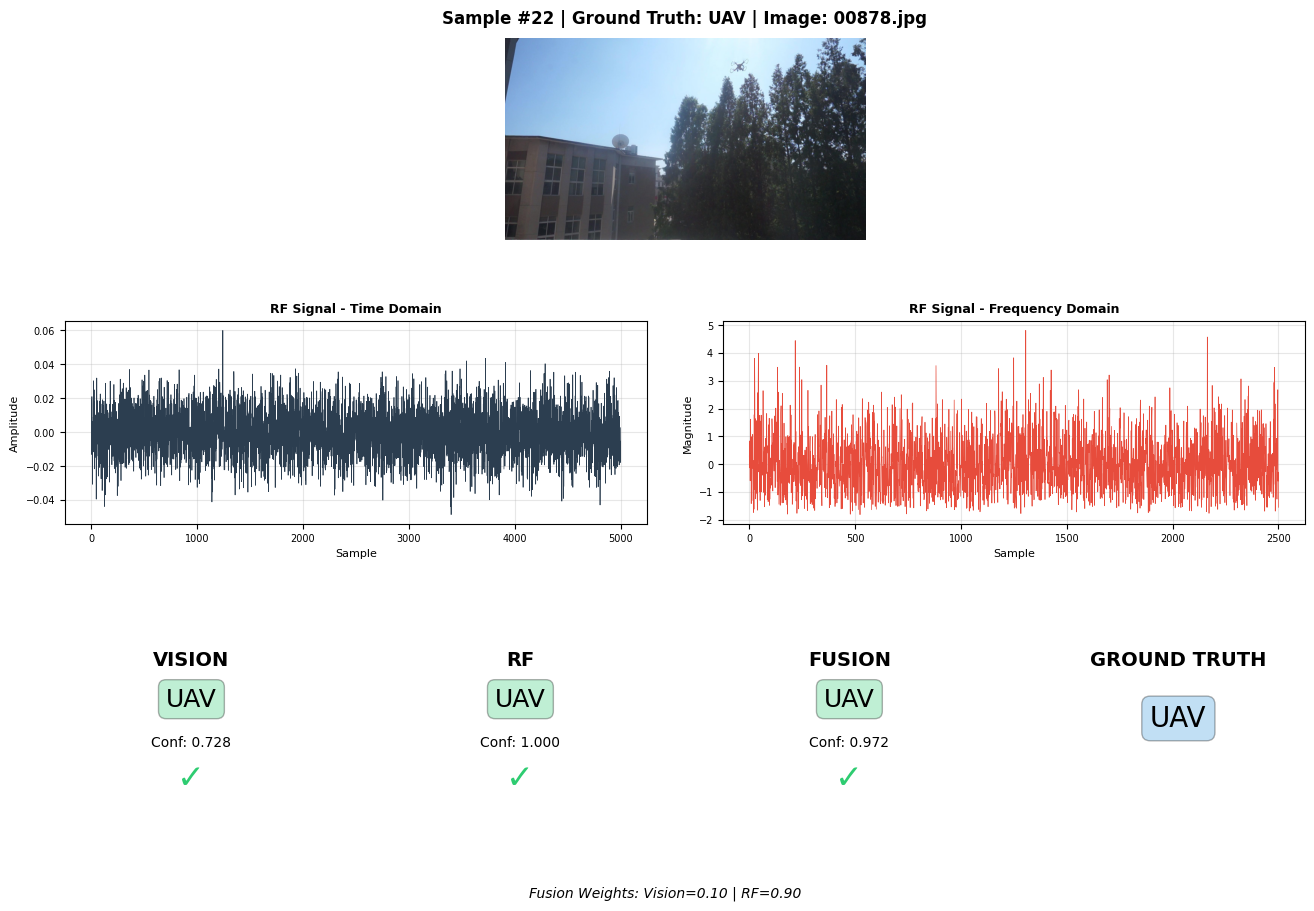

   💾 Saved: sample_083_UAV.png


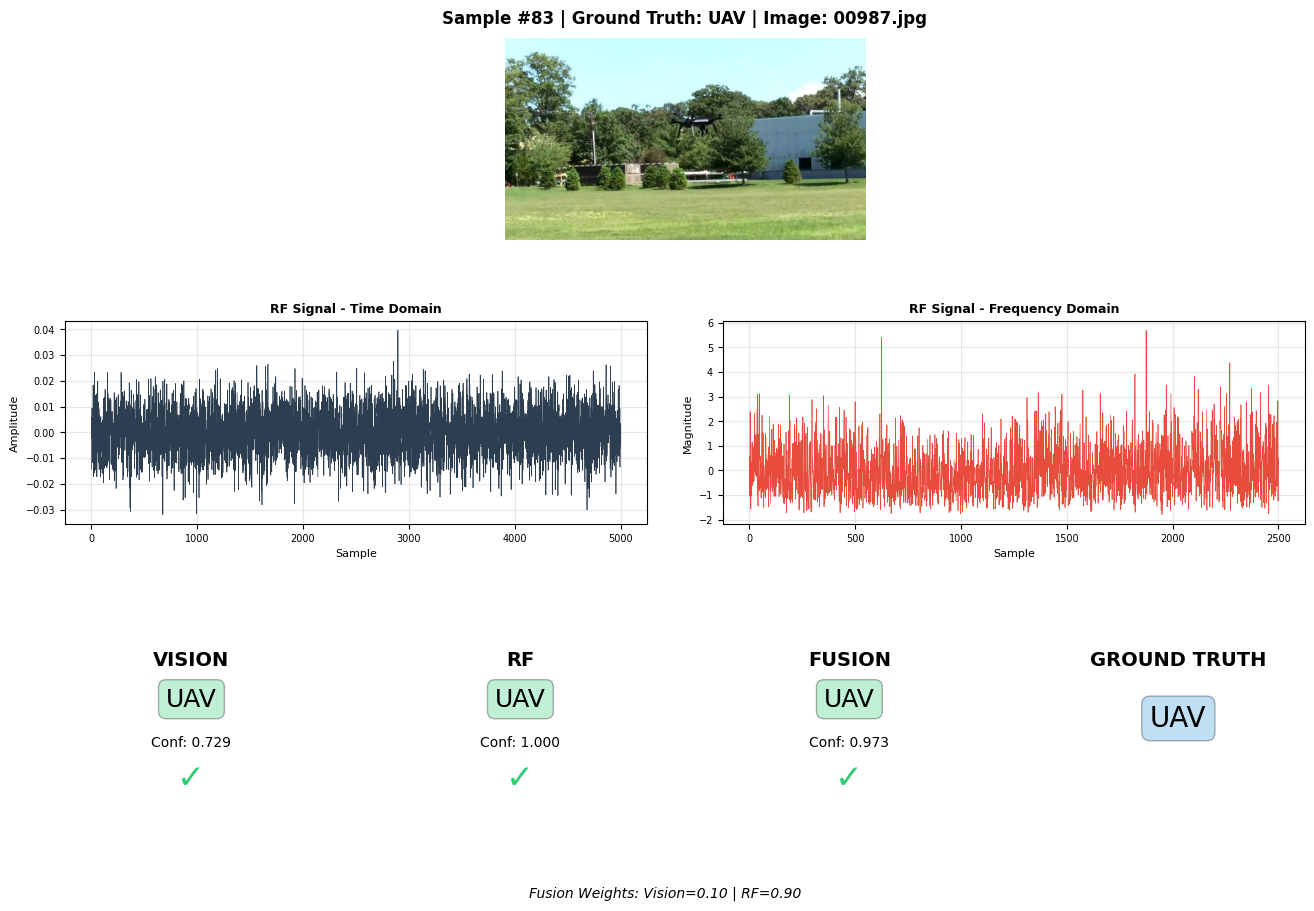

   💾 Saved: sample_011_UAV.png


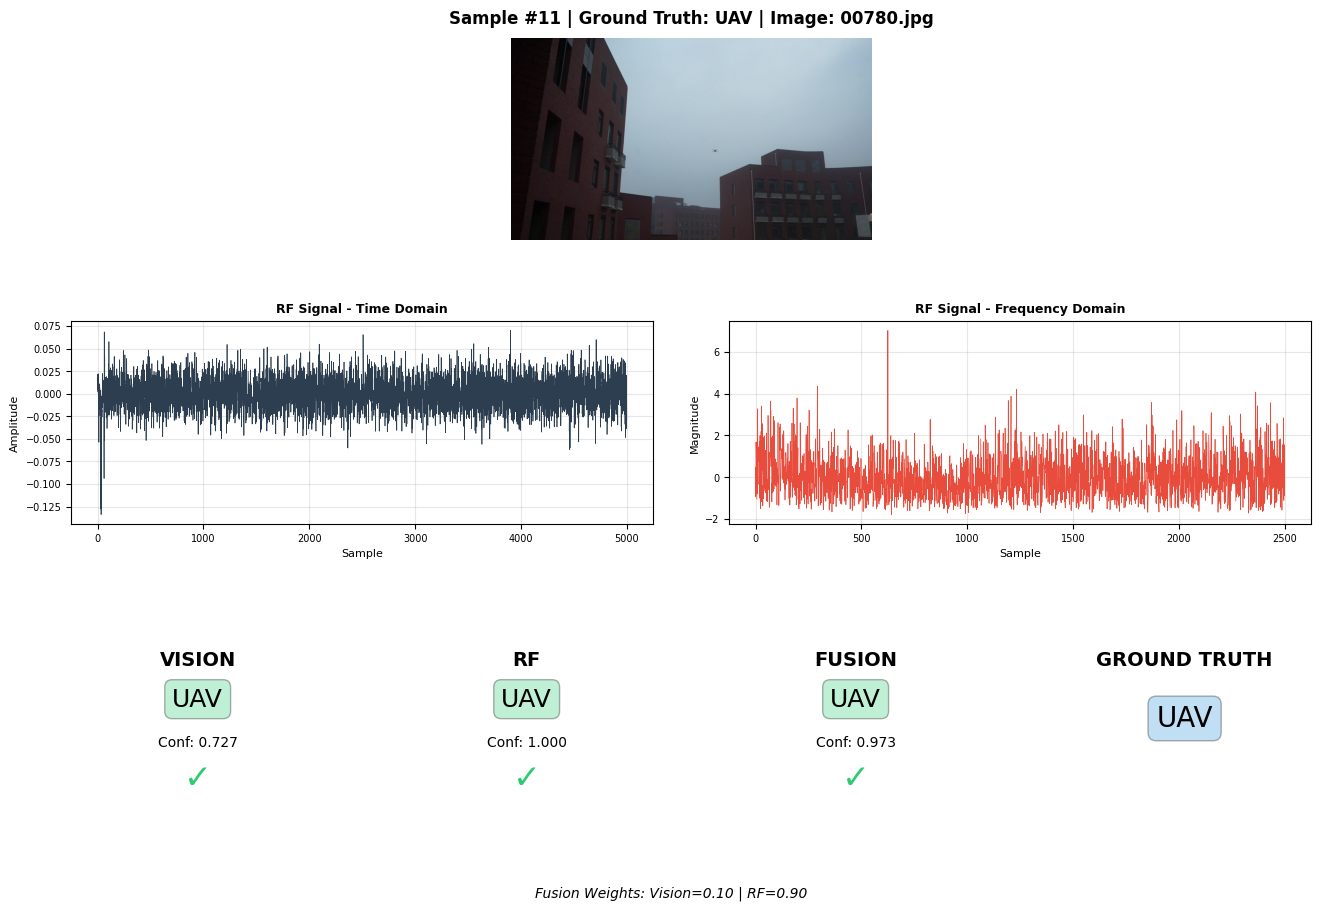

   💾 Saved: sample_081_UAV.png


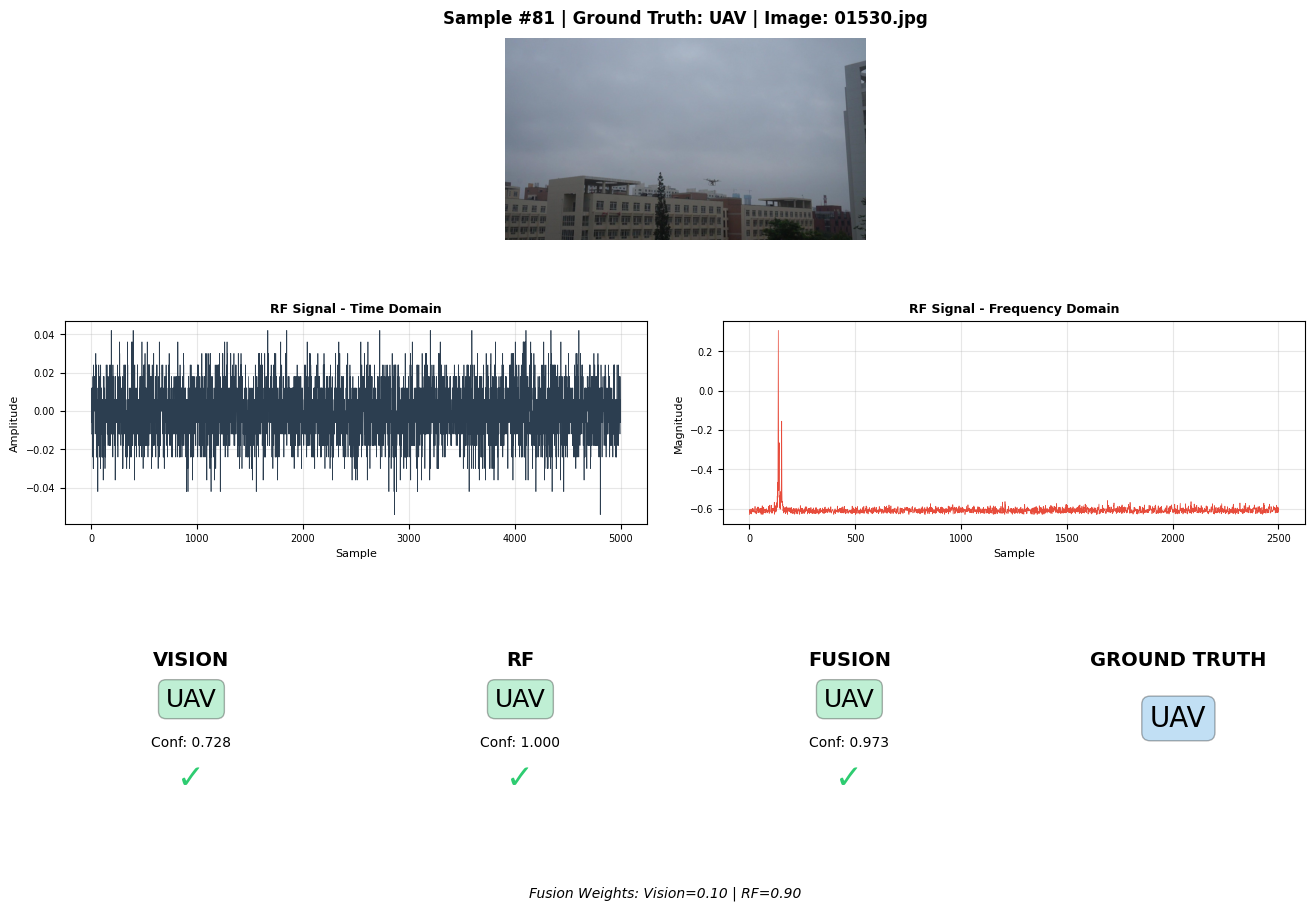

   💾 Saved: sample_016_UAV.png


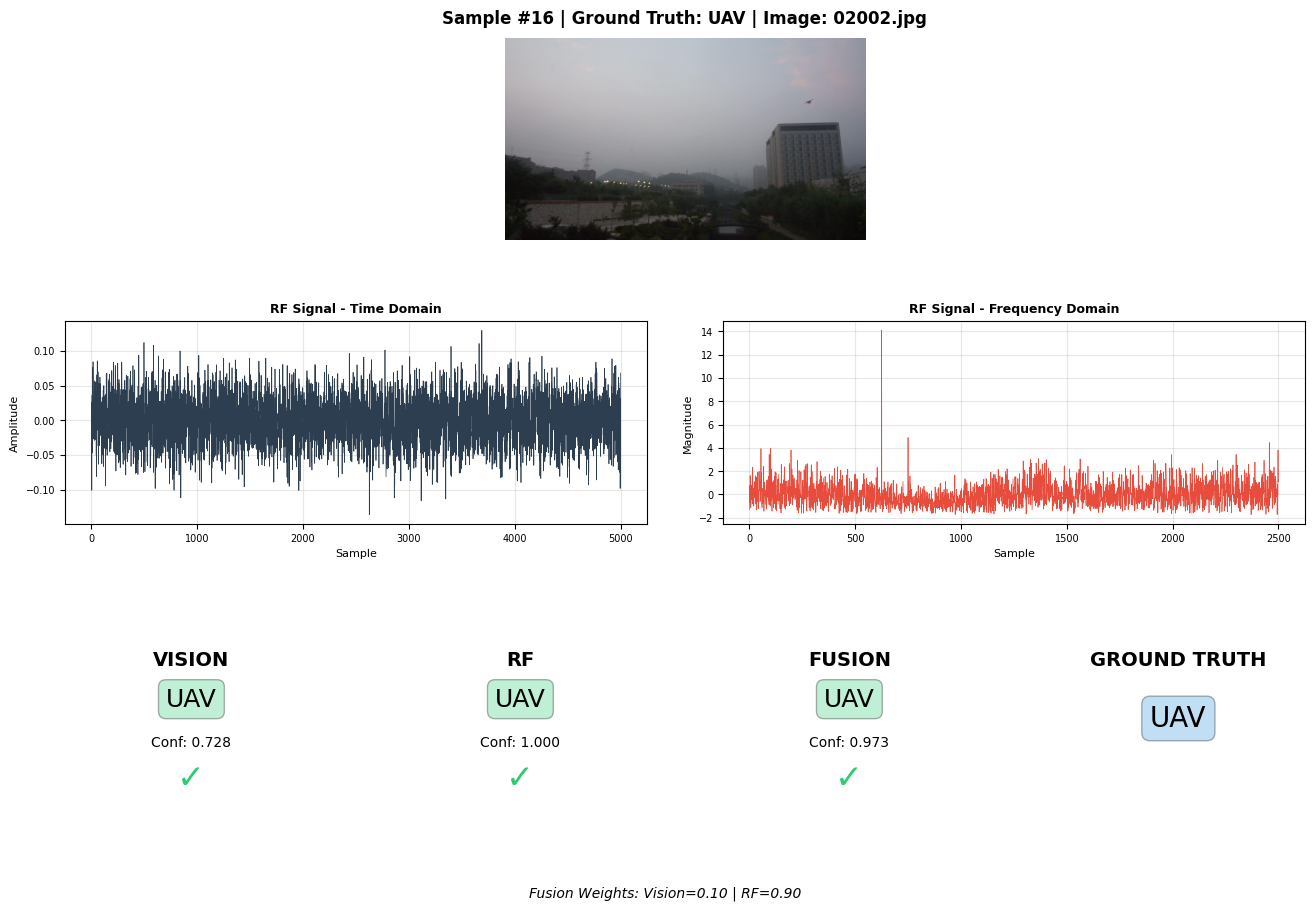

   💾 Saved: sample_006_Non-UAV.png


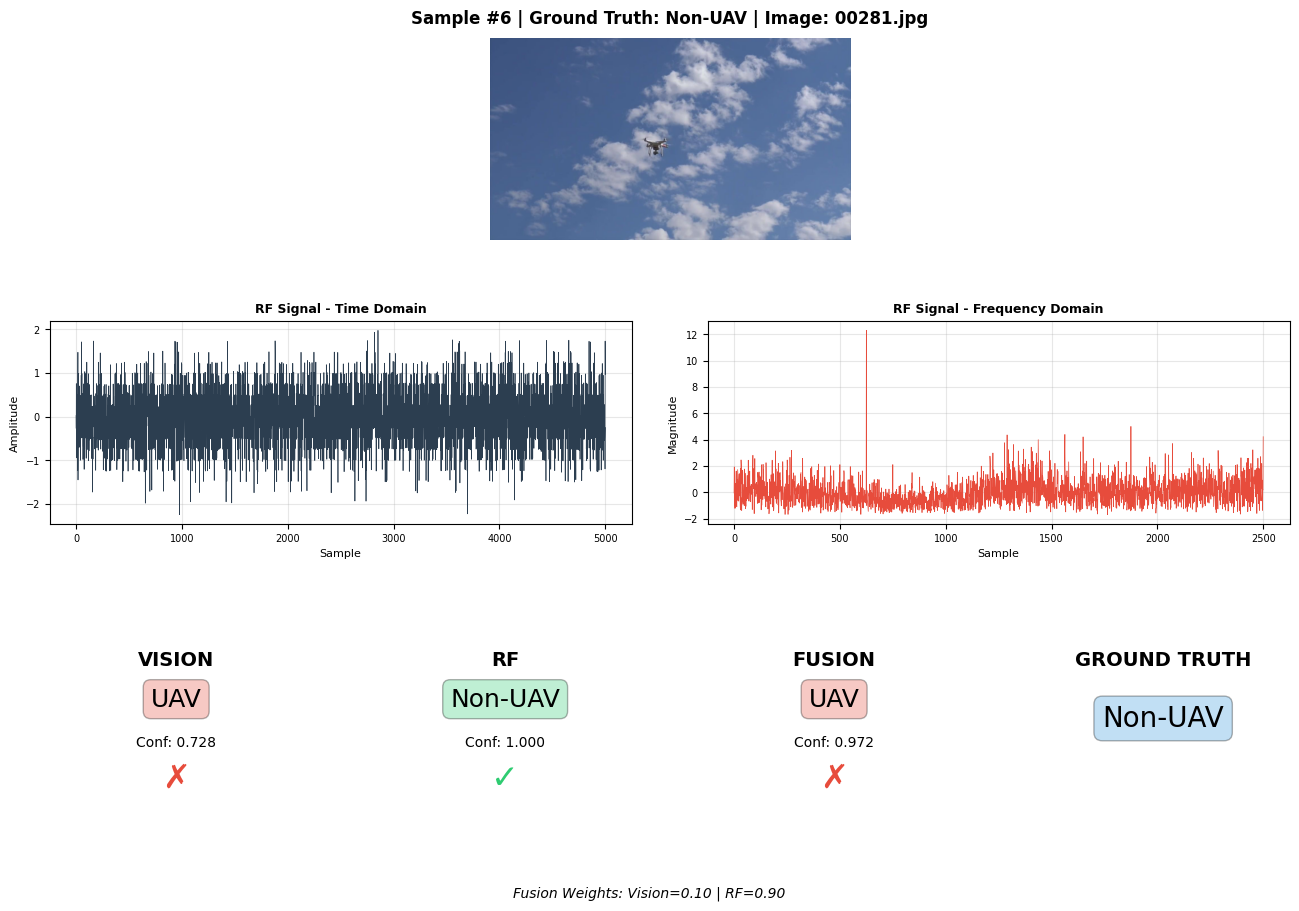

   💾 Saved: sample_010_Non-UAV.png


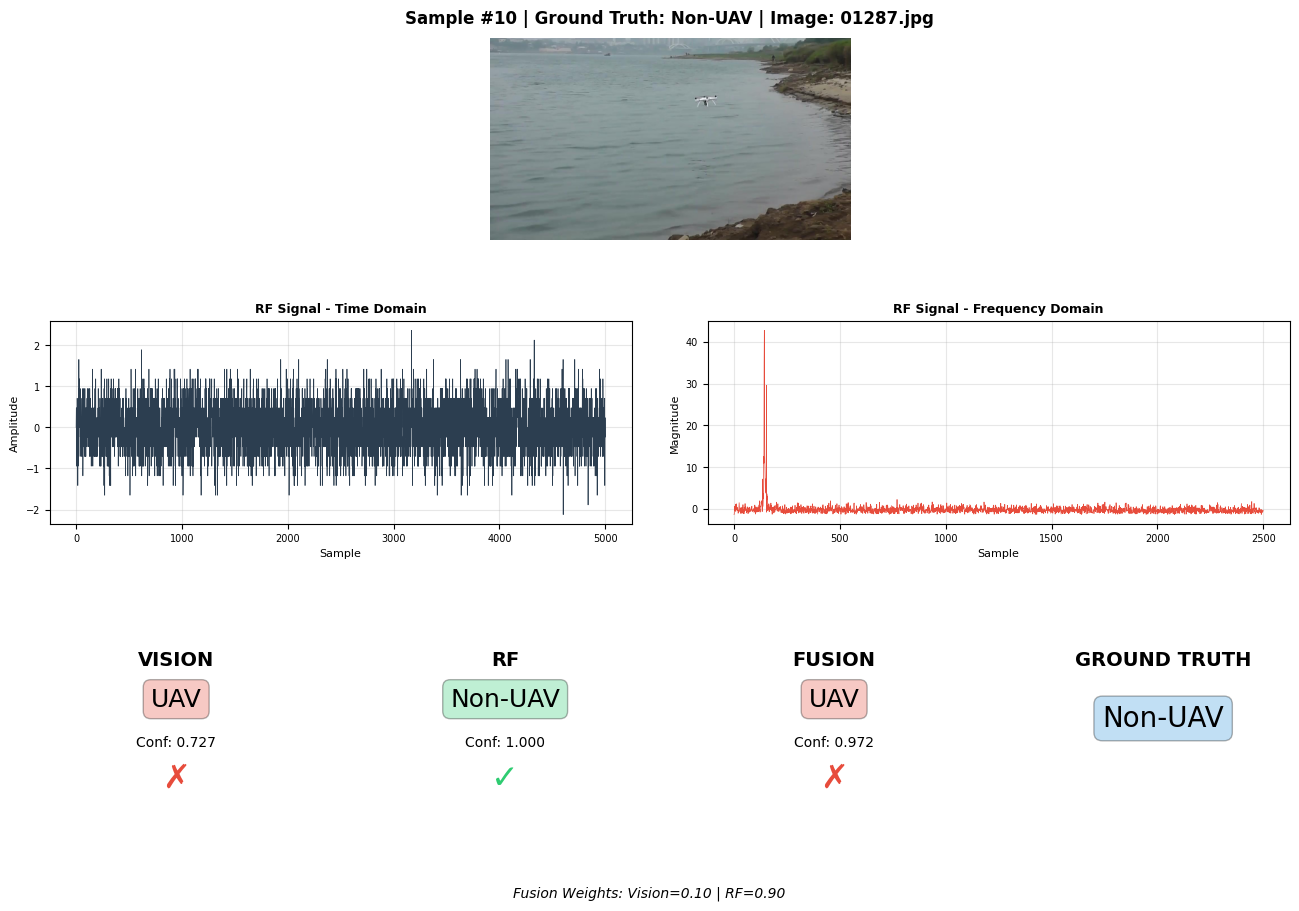

   💾 Saved: sample_040_Non-UAV.png


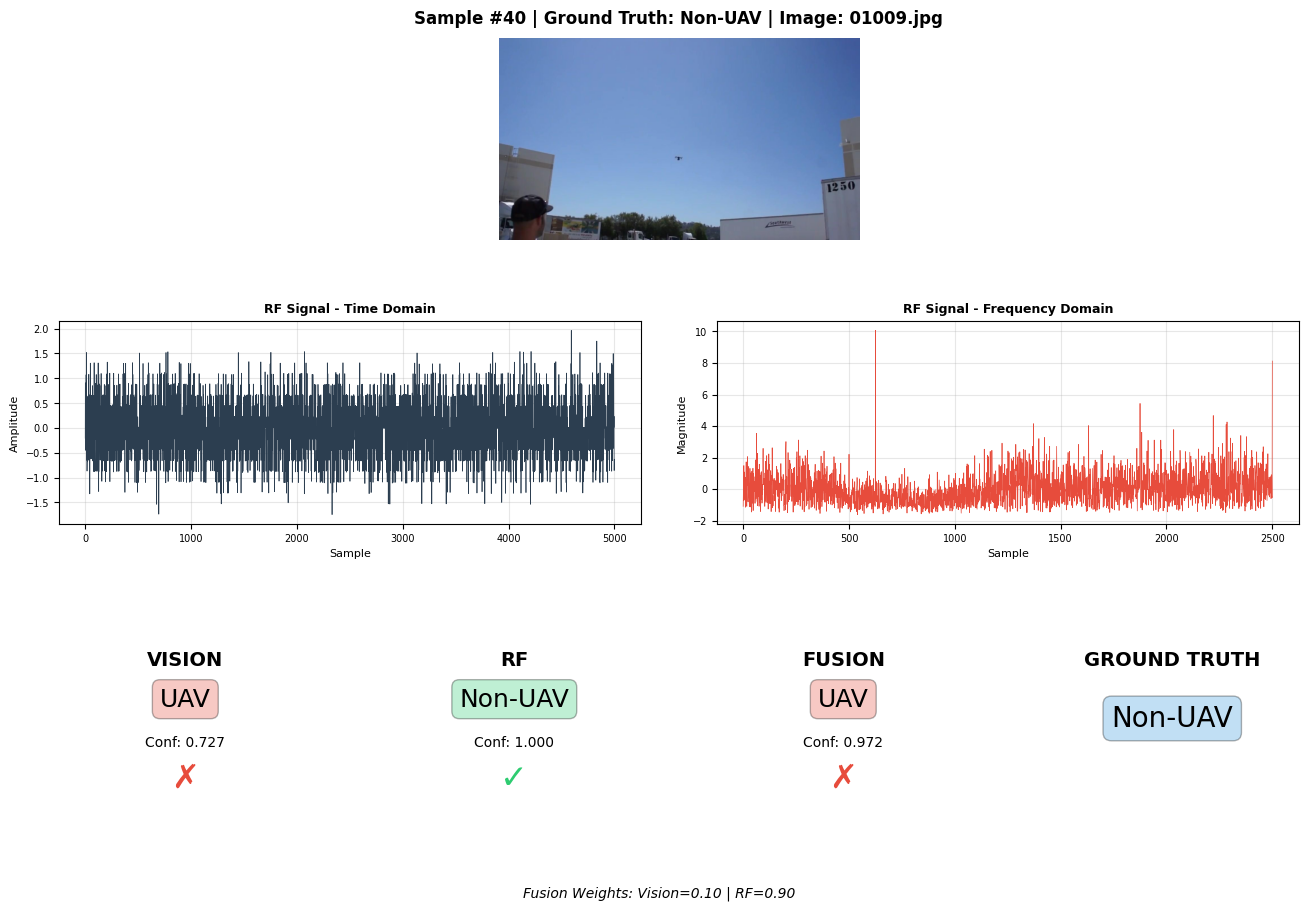

   💾 Saved: sample_077_Non-UAV.png


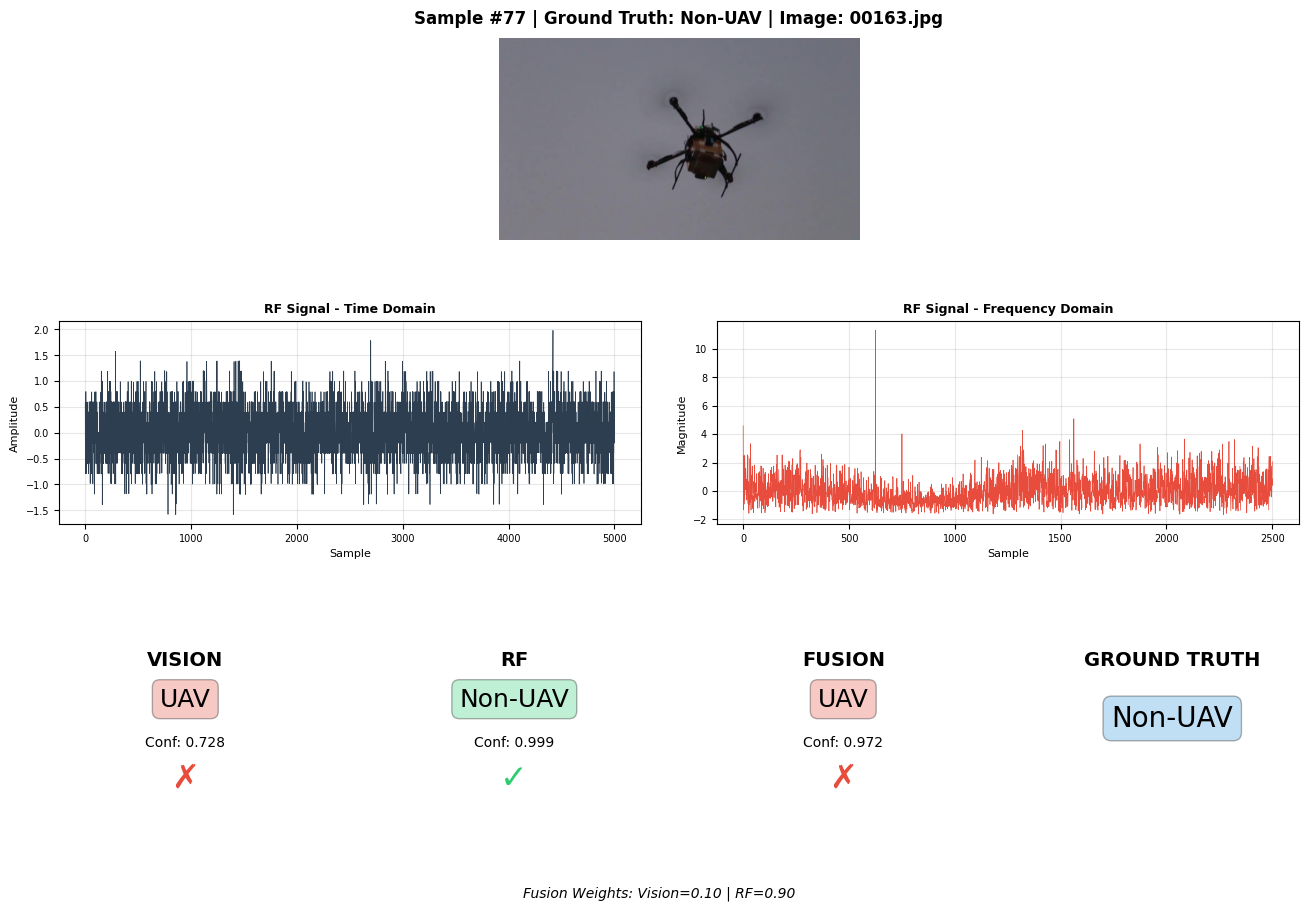

   💾 Saved: sample_051_Non-UAV.png


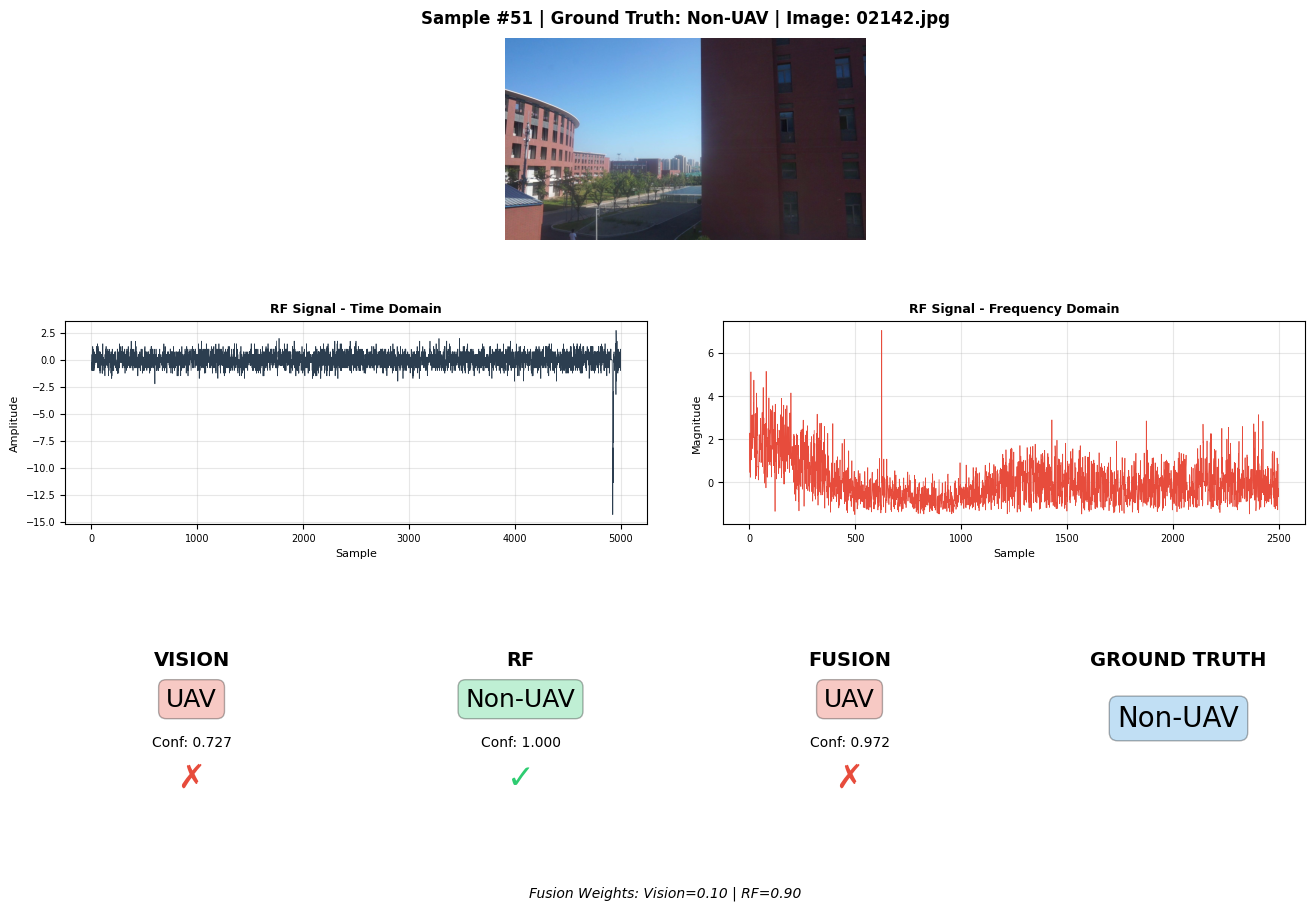


✅ All visualizations saved to: /content/drive/MyDrive/FYP_fusion_results/independent/plots/test_samples


In [36]:
# ============================================================================
# VISUALIZE TEST PAIRS WITH PREDICTIONS
# ============================================================================

print("="*80)
print("📸 VISUALIZING TEST PAIRS")
print("="*80)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np

# def plot_rf_signals(x_time, x_freq, ax_time, ax_freq, title_prefix=""):
#     """Plot RF time and frequency domain signals"""
#     # Time domain
#     ax_time.plot(x_time, linewidth=0.5, color='#2c3e50')
#     ax_time.set_title(f'{title_prefix}Time Domain', fontsize=9, fontweight='bold')
#     ax_time.set_xlabel('Sample', fontsize=8)
#     ax_time.set_ylabel('Amplitude', fontsize=8)
#     ax_time.grid(alpha=0.3)
#     ax_time.tick_params(labelsize=7)

#     # Frequency domain
#     ax_freq.plot(x_freq, linewidth=0.5, color='#e74c3c')
#     ax_freq.set_title(f'{title_prefix}Frequency Domain', fontsize=9, fontweight='bold')
#     ax_freq.set_xlabel('Sample', fontsize=8)
#     ax_freq.set_ylabel('Magnitude', fontsize=8)
#     ax_freq.grid(alpha=0.3)
#     ax_freq.tick_params(labelsize=7)



def plot_rf_signals(x_time, x_freq, ax_time, ax_freq, title_prefix=""):
    """Plot RF time and frequency domain signals"""

    # Flatten signals if they have extra dimensions
    if x_time.ndim > 1:
        x_time = x_time.flatten()
    if x_freq.ndim > 1:
        x_freq = x_freq.flatten()

    # Time domain
    ax_time.plot(x_time, linewidth=0.5, color='#2c3e50')
    ax_time.set_title(f'{title_prefix}Time Domain', fontsize=9, fontweight='bold')
    ax_time.set_xlabel('Sample', fontsize=8)
    ax_time.set_ylabel('Amplitude', fontsize=8)
    ax_time.grid(alpha=0.3)
    ax_time.tick_params(labelsize=7)

    # Frequency domain
    ax_freq.plot(x_freq, linewidth=0.5, color='#e74c3c')
    ax_freq.set_title(f'{title_prefix}Frequency Domain', fontsize=9, fontweight='bold')
    ax_freq.set_xlabel('Sample', fontsize=8)
    ax_freq.set_ylabel('Magnitude', fontsize=8)
    ax_freq.grid(alpha=0.3)
    ax_freq.tick_params(labelsize=7)


def visualize_test_pairs(test_pairs, test_vision_results, test_rf_results,
                         test_fusion_results, X_time_test, X_freq_test,
                         num_samples=10, save_dir=None):
    """
    Visualize test pairs with images, RF signals, and predictions

    Args:
        num_samples: Number of samples to visualize (default: 10)
        save_dir: Directory to save individual visualizations (optional)
    """

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # Select diverse samples
    num_samples = min(num_samples, len(test_pairs))

    # Get both correct and incorrect predictions
    correct_indices = []
    incorrect_indices = []

    for i, pair in enumerate(test_pairs):
        gt = pair['ground_truth']
        fusion_pred = 1 if test_fusion_results[i]['is_uav'] else 0

        if gt == fusion_pred:
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)

    # Balance the samples
    num_correct = min(num_samples // 2, len(correct_indices))
    num_incorrect = min(num_samples - num_correct, len(incorrect_indices))

    selected_indices = (
        np.random.choice(correct_indices, num_correct, replace=False).tolist() +
        np.random.choice(incorrect_indices, num_incorrect, replace=False).tolist()
    )

    print(f"\n📊 Visualizing {len(selected_indices)} test samples:")
    print(f"   ✅ Correct predictions: {num_correct}")
    print(f"   ❌ Incorrect predictions: {num_incorrect}")

    # Create visualization for each sample
    for idx in selected_indices:
        pair = test_pairs[idx]
        vision_result = test_vision_results[idx]
        rf_result = test_rf_results[idx]
        fusion_result = test_fusion_results[idx]

        rf_idx = pair['rf_index']
        gt = pair['ground_truth']
        gt_label = "UAV" if gt == 1 else "Non-UAV"

        # Create figure with 3 rows: Image, RF signals, Predictions
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

        # ===== ROW 1: UAV IMAGE =====
        ax_img = fig.add_subplot(gs[0, :])

        img_path = os.path.join(VISION_TEST_IMG, pair['vision_image'])
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            ax_img.imshow(img)
        else:
            ax_img.text(0.5, 0.5, 'Image Not Found', ha='center', va='center')

        ax_img.axis('off')
        ax_img.set_title(f"Sample #{idx} | Ground Truth: {gt_label} | Image: {pair['vision_image']}",
                        fontsize=12, fontweight='bold', pad=10)

        # ===== ROW 2: RF SIGNALS =====
        ax_time = fig.add_subplot(gs[1, 0:2])
        ax_freq = fig.add_subplot(gs[1, 2:4])

        plot_rf_signals(X_time_test[rf_idx], X_freq_test[rf_idx],
                       ax_time, ax_freq, title_prefix="RF Signal - ")

        # ===== ROW 3: PREDICTIONS =====
        # Vision prediction
        ax_vis = fig.add_subplot(gs[2, 0])
        vision_pred = "UAV" if vision_result['has_uav'] else "Non-UAV"
        vision_correct = (vision_result['has_uav'] == (gt == 1))
        color_vis = '#2ecc71' if vision_correct else '#e74c3c'

        ax_vis.text(0.5, 0.7, 'VISION', ha='center', fontsize=14, fontweight='bold')
        ax_vis.text(0.5, 0.5, vision_pred, ha='center', fontsize=18,
                   bbox=dict(boxstyle='round', facecolor=color_vis, alpha=0.3))
        ax_vis.text(0.5, 0.3, f'Conf: {vision_result["confidence"]:.3f}',
                   ha='center', fontsize=10)
        ax_vis.text(0.5, 0.1, '✓' if vision_correct else '✗',
                   ha='center', fontsize=24, color=color_vis)
        ax_vis.axis('off')

        # RF prediction
        ax_rf = fig.add_subplot(gs[2, 1])
        rf_pred = "UAV" if rf_result['is_uav'] else "Non-UAV"
        rf_correct = (rf_result['is_uav'] == (gt == 1))
        color_rf = '#2ecc71' if rf_correct else '#e74c3c'

        ax_rf.text(0.5, 0.7, 'RF', ha='center', fontsize=14, fontweight='bold')
        ax_rf.text(0.5, 0.5, rf_pred, ha='center', fontsize=18,
                  bbox=dict(boxstyle='round', facecolor=color_rf, alpha=0.3))
        ax_rf.text(0.5, 0.3, f'Conf: {rf_result["confidence"]:.3f}',
                  ha='center', fontsize=10)
        ax_rf.text(0.5, 0.1, '✓' if rf_correct else '✗',
                  ha='center', fontsize=24, color=color_rf)
        ax_rf.axis('off')

        # Fusion prediction
        ax_fusion = fig.add_subplot(gs[2, 2])
        fusion_pred = "UAV" if fusion_result['is_uav'] else "Non-UAV"
        fusion_correct = (fusion_result['is_uav'] == (gt == 1))
        color_fusion = '#2ecc71' if fusion_correct else '#e74c3c'

        ax_fusion.text(0.5, 0.7, 'FUSION', ha='center', fontsize=14, fontweight='bold')
        ax_fusion.text(0.5, 0.5, fusion_pred, ha='center', fontsize=18,
                      bbox=dict(boxstyle='round', facecolor=color_fusion, alpha=0.3))
        ax_fusion.text(0.5, 0.3, f'Conf: {fusion_result["confidence"]:.3f}',
                      ha='center', fontsize=10)
        ax_fusion.text(0.5, 0.1, '✓' if fusion_correct else '✗',
                      ha='center', fontsize=24, color=color_fusion)
        ax_fusion.axis('off')

        # Ground truth box
        ax_gt = fig.add_subplot(gs[2, 3])
        ax_gt.text(0.5, 0.7, 'GROUND TRUTH', ha='center', fontsize=14, fontweight='bold')
        ax_gt.text(0.5, 0.4, gt_label, ha='center', fontsize=20,
                  bbox=dict(boxstyle='round', facecolor='#3498db', alpha=0.3))
        ax_gt.axis('off')

        # Add fusion weights info
        fig.text(0.5, 0.02,
                f'Fusion Weights: Vision={best_fusion.weights["vision"]:.2f} | RF={best_fusion.weights["rf"]:.2f}',
                ha='center', fontsize=10, style='italic')

        # Save individual visualization
        if save_dir:
            save_path = os.path.join(save_dir, f'sample_{idx:03d}_{gt_label}.png')
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"   💾 Saved: sample_{idx:03d}_{gt_label}.png")

        plt.show()
        plt.close()

# Visualize test pairs
viz_dir = os.path.join(PLOTS_DIR, 'test_samples')
visualize_test_pairs(
    test_pairs=test_pairs,
    test_vision_results=test_vision_results,
    test_rf_results=test_rf_results,
    test_fusion_results=test_fusion_results,
    X_time_test=X_time_test,
    X_freq_test=X_freq_test,
    num_samples=10,  # Change this to visualize more/fewer samples
    save_dir=viz_dir
)

print(f"\n✅ All visualizations saved to: {viz_dir}")
print("="*80)


Create Comprehensive Grid View

📊 CREATING GRID VIEW
✅ Grid view saved: /content/drive/MyDrive/FYP_fusion_results/independent/plots/grid_view.png


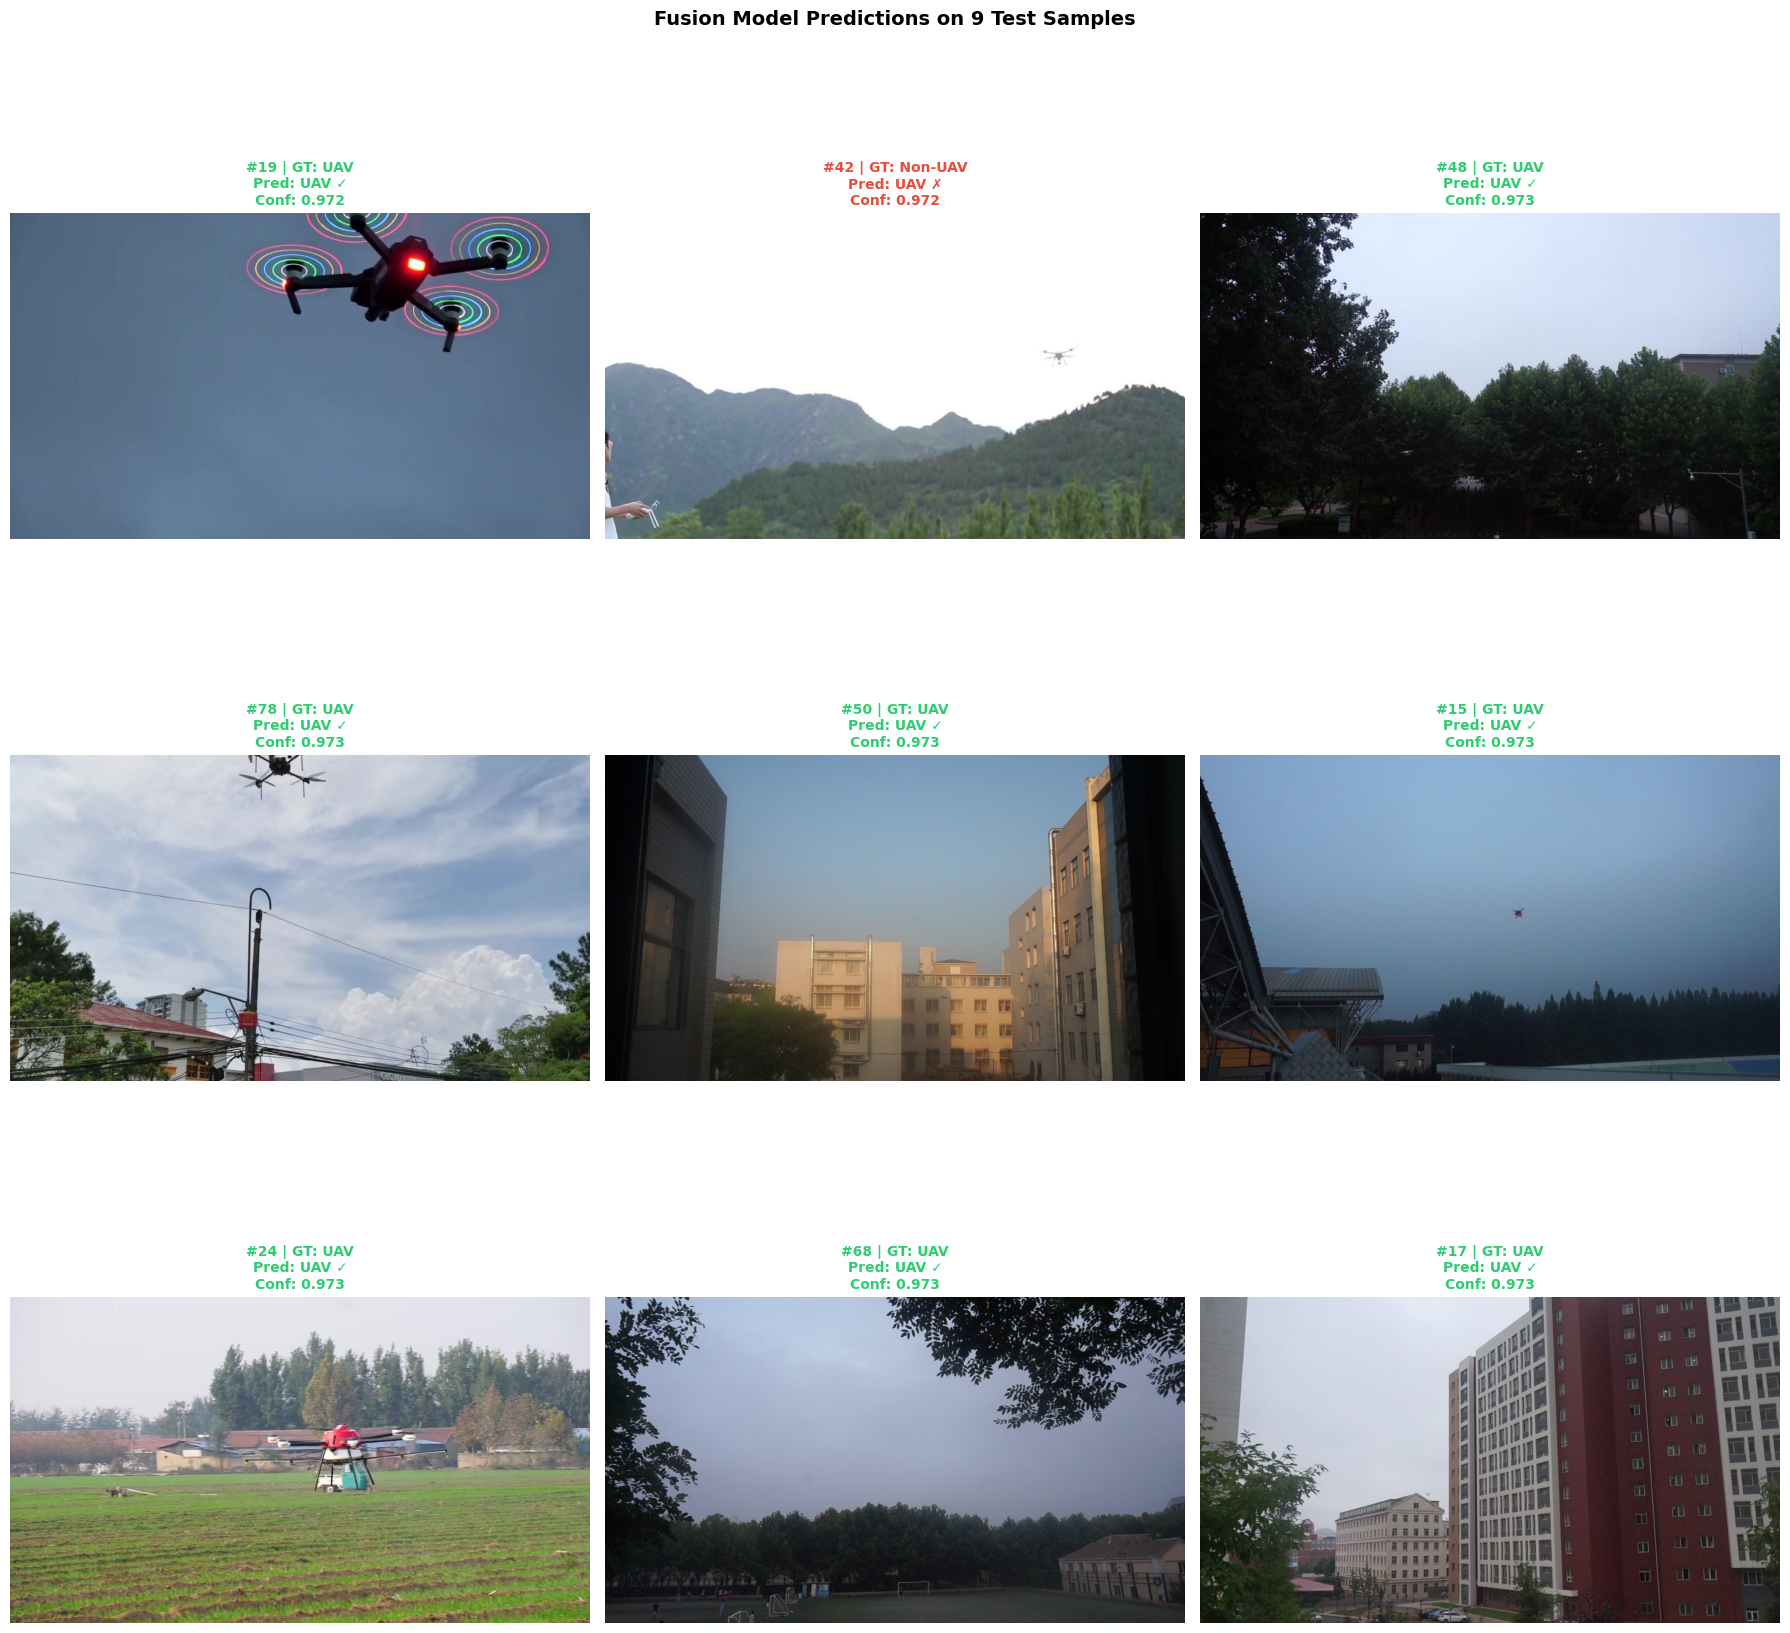

In [32]:
# ============================================================================
# GRID VIEW: MULTIPLE SAMPLES AT ONCE
# ============================================================================

print("="*80)
print("📊 CREATING GRID VIEW")
print("="*80)

def create_grid_visualization(test_pairs, test_vision_results, test_rf_results,
                              test_fusion_results, X_time_test, X_freq_test,
                              num_samples=6, save_path=None):
    """Create a compact grid view of multiple samples"""

    num_samples = min(num_samples, len(test_pairs))
    selected_indices = np.random.choice(len(test_pairs), num_samples, replace=False)

    # Calculate grid dimensions
    cols = 3
    rows = (num_samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    axes = axes.flatten() if num_samples > 1 else [axes]

    for i, idx in enumerate(selected_indices):
        pair = test_pairs[idx]
        fusion_result = test_fusion_results[idx]
        gt = pair['ground_truth']

        # Load image
        img_path = os.path.join(VISION_TEST_IMG, pair['vision_image'])
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            axes[i].imshow(img)

        # Prediction info
        fusion_pred = 1 if fusion_result['is_uav'] else 0
        is_correct = (fusion_pred == gt)

        gt_label = "UAV" if gt == 1 else "Non-UAV"
        pred_label = "UAV" if fusion_pred == 1 else "Non-UAV"

        color = '#2ecc71' if is_correct else '#e74c3c'
        symbol = '✓' if is_correct else '✗'

        title = f"#{idx} | GT: {gt_label}\nPred: {pred_label} {symbol}\nConf: {fusion_result['confidence']:.3f}"
        axes[i].set_title(title, fontsize=10, fontweight='bold', color=color)
        axes[i].axis('off')

    # Hide unused subplots
    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Fusion Model Predictions on {num_samples} Test Samples',
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f"✅ Grid view saved: {save_path}")

    plt.show()
    plt.close()

# Create grid view
create_grid_visualization(
    test_pairs=test_pairs,
    test_vision_results=test_vision_results,
    test_rf_results=test_rf_results,
    test_fusion_results=test_fusion_results,
    X_time_test=X_time_test,
    X_freq_test=X_freq_test,
    num_samples=9,  # 3x3 grid
    save_path=os.path.join(PLOTS_DIR, 'grid_view.png')
)

print("="*80)


RF Signal Spectrogram Visualization

📡 CREATING RF SPECTROGRAMS


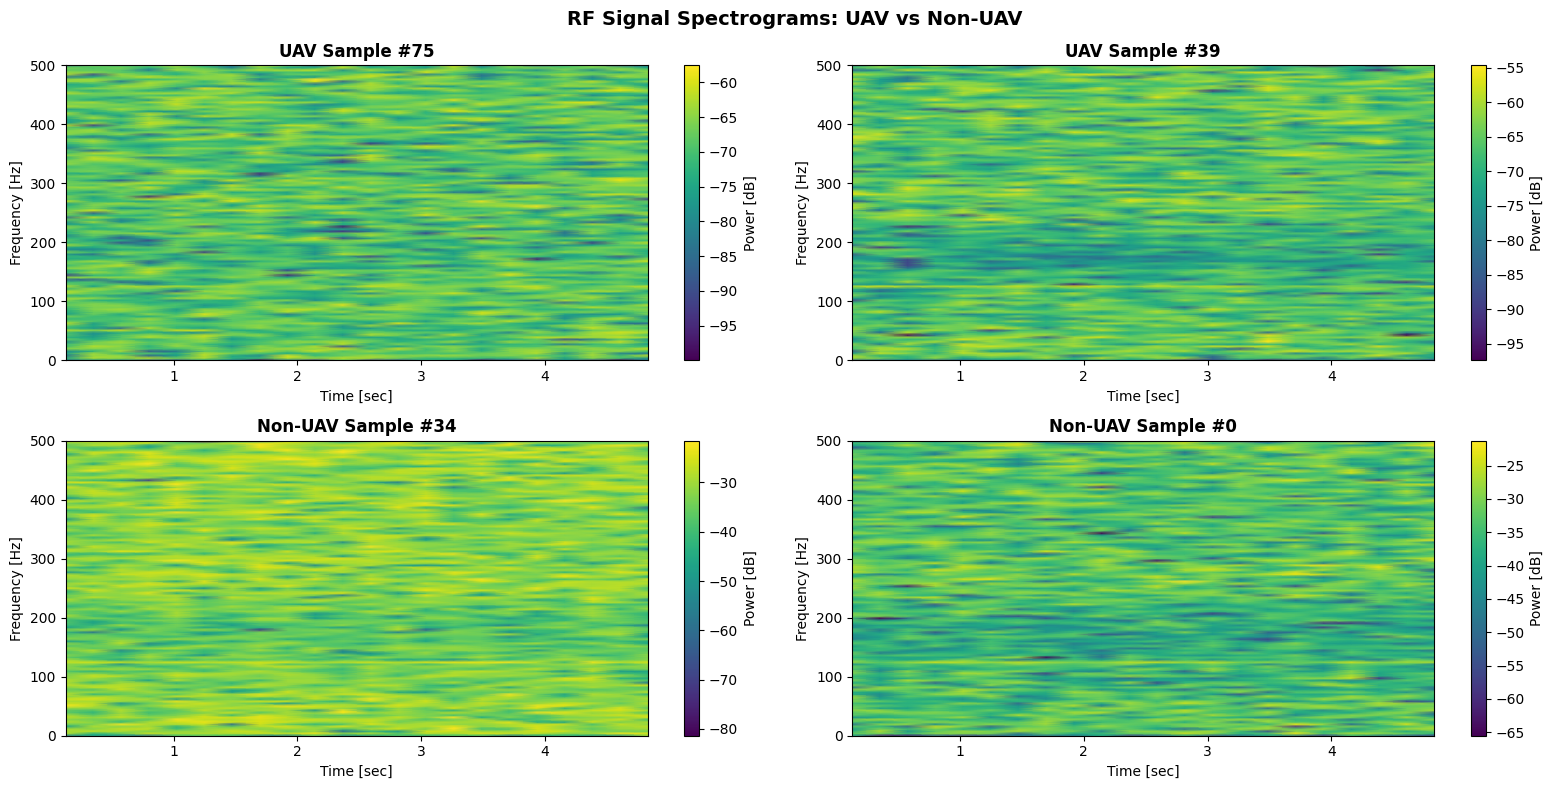

✅ Spectrograms saved: /content/drive/MyDrive/FYP_fusion_results/independent/plots/rf_spectrograms.png


In [34]:
# ============================================================================
# RF SPECTROGRAM VISUALIZATION
# ============================================================================

print("="*80)
print("📡 CREATING RF SPECTROGRAMS")
print("="*80)

from scipy.signal import spectrogram

def plot_rf_spectrogram(x_time, sample_rate=1000, ax=None, title="RF Spectrogram"):
    """Create spectrogram of RF time-domain signal"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))

    # Flatten the signal if it has extra dimensions
    if x_time.ndim > 1:
        x_time = x_time.flatten()

    # Compute spectrogram
    f, t, Sxx = spectrogram(x_time, fs=sample_rate, nperseg=min(256, len(x_time)//4))

    # Plot
    im = ax.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10),
                       shading='gouraud', cmap='viridis')
    ax.set_ylabel('Frequency [Hz]', fontsize=10)
    ax.set_xlabel('Time [sec]', fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')

    plt.colorbar(im, ax=ax, label='Power [dB]')

    return ax

def visualize_rf_spectrograms(test_pairs, X_time_test, num_samples=4):
    """Visualize RF spectrograms for UAV and Non-UAV samples"""

    # Get UAV and Non-UAV samples
    uav_indices = [i for i, pair in enumerate(test_pairs) if pair['ground_truth'] == 1]
    non_uav_indices = [i for i, pair in enumerate(test_pairs) if pair['ground_truth'] == 0]

    num_each = num_samples // 2

    if len(uav_indices) < num_each or len(non_uav_indices) < num_each:
        print(f"⚠️  Not enough samples. Found {len(uav_indices)} UAV, {len(non_uav_indices)} Non-UAV")
        num_each = min(len(uav_indices), len(non_uav_indices), num_each)

    selected_uav = np.random.choice(uav_indices, num_each, replace=False)
    selected_non_uav = np.random.choice(non_uav_indices, num_each, replace=False)

    fig, axes = plt.subplots(2, num_each, figsize=(16, 8))

    # Ensure axes is 2D array
    if num_each == 1:
        axes = axes.reshape(2, 1)

    # Plot UAV samples
    for i, idx in enumerate(selected_uav):
        rf_idx = test_pairs[idx]['rf_index']
        plot_rf_spectrogram(X_time_test[rf_idx], ax=axes[0, i],
                           title=f"UAV Sample #{idx}")

    # Plot Non-UAV samples
    for i, idx in enumerate(selected_non_uav):
        rf_idx = test_pairs[idx]['rf_index']
        plot_rf_spectrogram(X_time_test[rf_idx], ax=axes[1, i],
                           title=f"Non-UAV Sample #{idx}")

    plt.suptitle('RF Signal Spectrograms: UAV vs Non-UAV',
                fontsize=14, fontweight='bold')
    plt.tight_layout()

    save_path = os.path.join(PLOTS_DIR, 'rf_spectrograms.png')
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

    print(f"✅ Spectrograms saved: {save_path}")

# Create spectrograms
visualize_rf_spectrograms(test_pairs, X_time_test, num_samples=4)

print("="*80)


📡 COMPARING RF SIGNALS


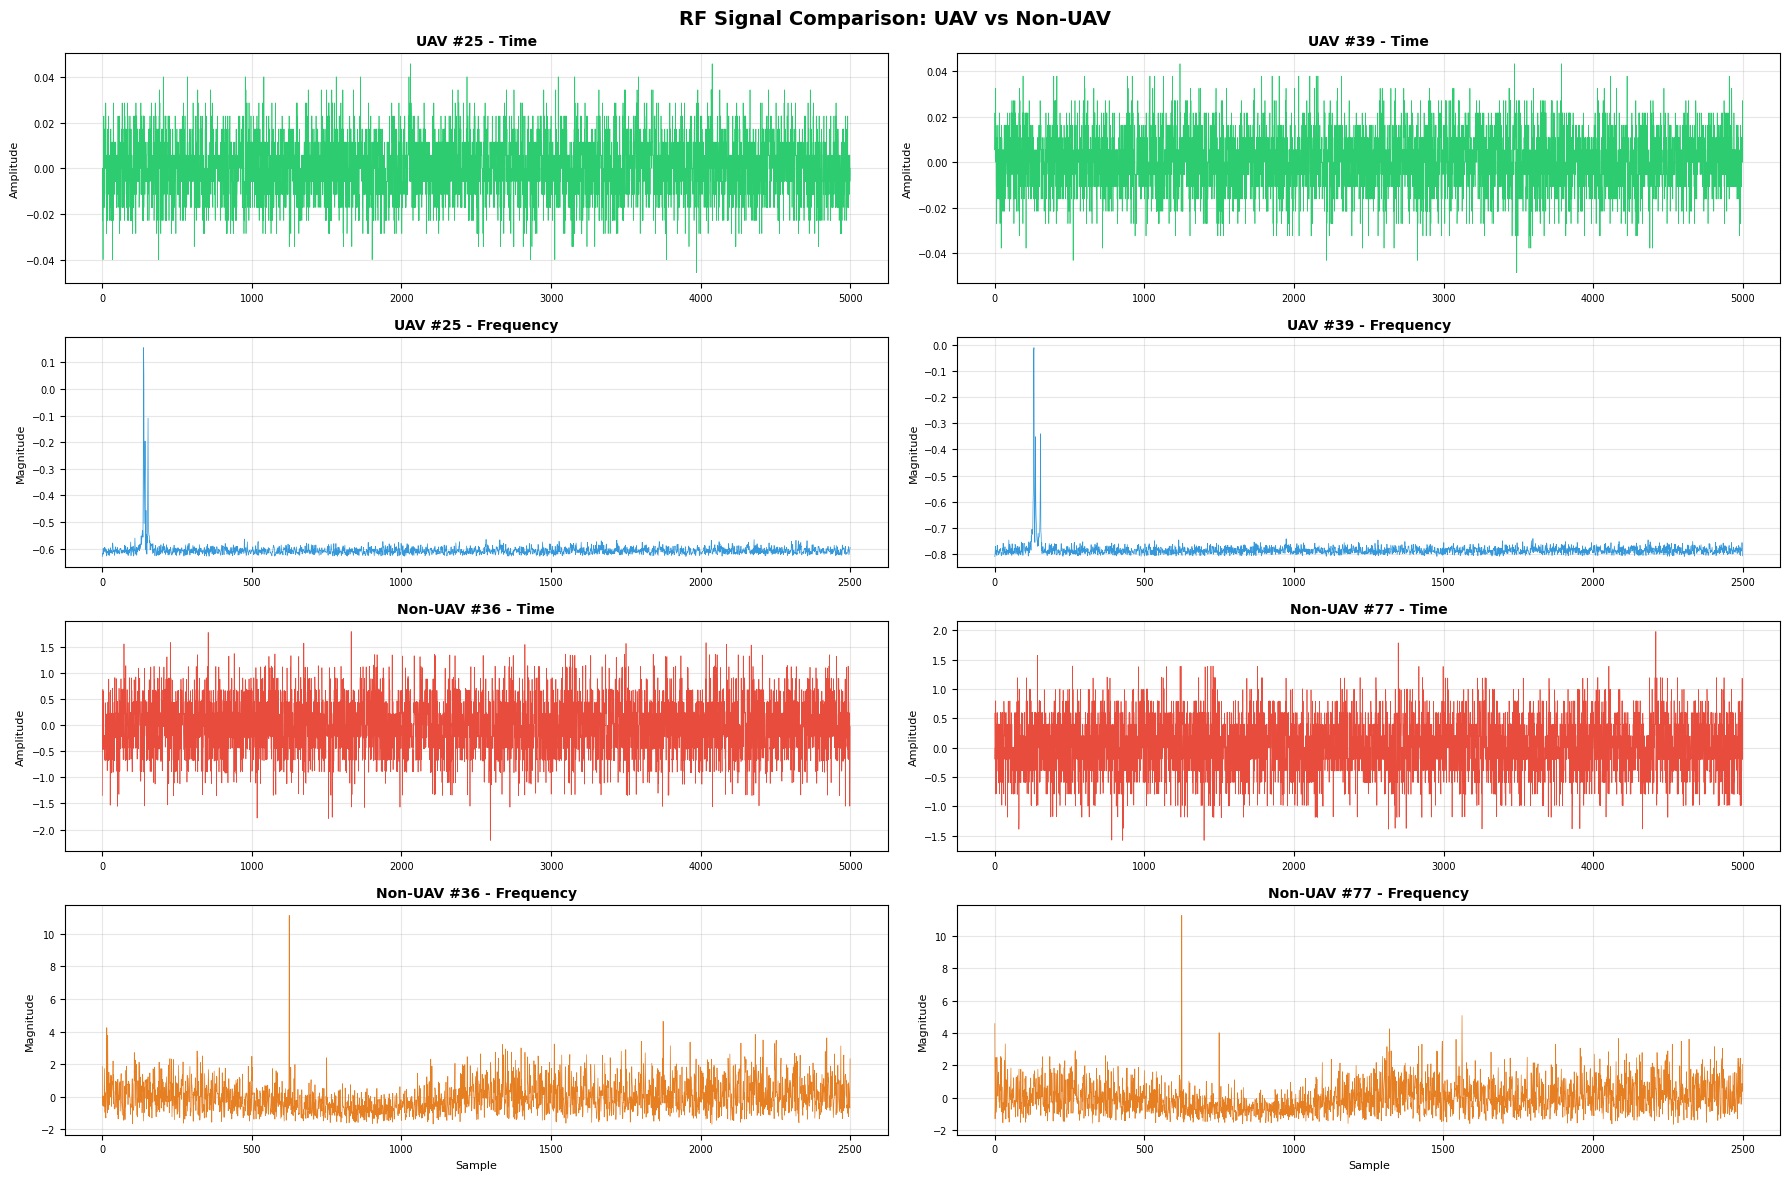

✅ RF comparison saved: /content/drive/MyDrive/FYP_fusion_results/independent/plots/rf_signal_comparison.png


In [35]:
# ============================================================================
# RF SIGNAL COMPARISON: UAV vs NON-UAV
# ============================================================================

print("="*80)
print("📡 COMPARING RF SIGNALS")
print("="*80)

def compare_rf_signals(test_pairs, X_time_test, X_freq_test, num_samples=4):
    """Compare RF signals for UAV and Non-UAV samples"""

    # Get UAV and Non-UAV samples
    uav_indices = [i for i, pair in enumerate(test_pairs) if pair['ground_truth'] == 1]
    non_uav_indices = [i for i, pair in enumerate(test_pairs) if pair['ground_truth'] == 0]

    num_each = min(num_samples // 2, len(uav_indices), len(non_uav_indices))

    selected_uav = np.random.choice(uav_indices, num_each, replace=False)
    selected_non_uav = np.random.choice(non_uav_indices, num_each, replace=False)

    fig, axes = plt.subplots(4, num_each, figsize=(18, 12))

    if num_each == 1:
        axes = axes.reshape(4, 1)

    # Plot UAV samples
    for i, idx in enumerate(selected_uav):
        rf_idx = test_pairs[idx]['rf_index']

        # Flatten signals
        time_signal = X_time_test[rf_idx].flatten()
        freq_signal = X_freq_test[rf_idx].flatten()

        # Time domain
        axes[0, i].plot(time_signal, linewidth=0.5, color='#2ecc71')
        axes[0, i].set_title(f'UAV #{idx} - Time', fontsize=10, fontweight='bold')
        axes[0, i].set_ylabel('Amplitude', fontsize=8)
        axes[0, i].grid(alpha=0.3)
        axes[0, i].tick_params(labelsize=7)

        # Frequency domain
        axes[1, i].plot(freq_signal, linewidth=0.5, color='#3498db')
        axes[1, i].set_title(f'UAV #{idx} - Frequency', fontsize=10, fontweight='bold')
        axes[1, i].set_ylabel('Magnitude', fontsize=8)
        axes[1, i].grid(alpha=0.3)
        axes[1, i].tick_params(labelsize=7)

    # Plot Non-UAV samples
    for i, idx in enumerate(selected_non_uav):
        rf_idx = test_pairs[idx]['rf_index']

        # Flatten signals
        time_signal = X_time_test[rf_idx].flatten()
        freq_signal = X_freq_test[rf_idx].flatten()

        # Time domain
        axes[2, i].plot(time_signal, linewidth=0.5, color='#e74c3c')
        axes[2, i].set_title(f'Non-UAV #{idx} - Time', fontsize=10, fontweight='bold')
        axes[2, i].set_ylabel('Amplitude', fontsize=8)
        axes[2, i].grid(alpha=0.3)
        axes[2, i].tick_params(labelsize=7)

        # Frequency domain
        axes[3, i].plot(freq_signal, linewidth=0.5, color='#e67e22')
        axes[3, i].set_title(f'Non-UAV #{idx} - Frequency', fontsize=10, fontweight='bold')
        axes[3, i].set_ylabel('Magnitude', fontsize=8)
        axes[3, i].set_xlabel('Sample', fontsize=8)
        axes[3, i].grid(alpha=0.3)
        axes[3, i].tick_params(labelsize=7)

    plt.suptitle('RF Signal Comparison: UAV vs Non-UAV',
                fontsize=14, fontweight='bold')
    plt.tight_layout()

    save_path = os.path.join(PLOTS_DIR, 'rf_signal_comparison.png')
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

    print(f"✅ RF comparison saved: {save_path}")

# Compare RF signals
compare_rf_signals(test_pairs, X_time_test, X_freq_test, num_samples=4)

print("="*80)
